# Analysis of differential cell abundance in time - Lymphoid cells

In this notebook we test for differential abundance in immune cell populations using [Milo](https://www.biorxiv.org/content/10.1101/2020.11.23.393769v1) (python implementation [milopy](https://github.com/emdann/milopy))

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [24]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [25]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/milo_analysis_LYMPHOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [26]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [27]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [29]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load data

In [30]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="LYMPHOID"

In [10]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
adata.var_names_make_unique()

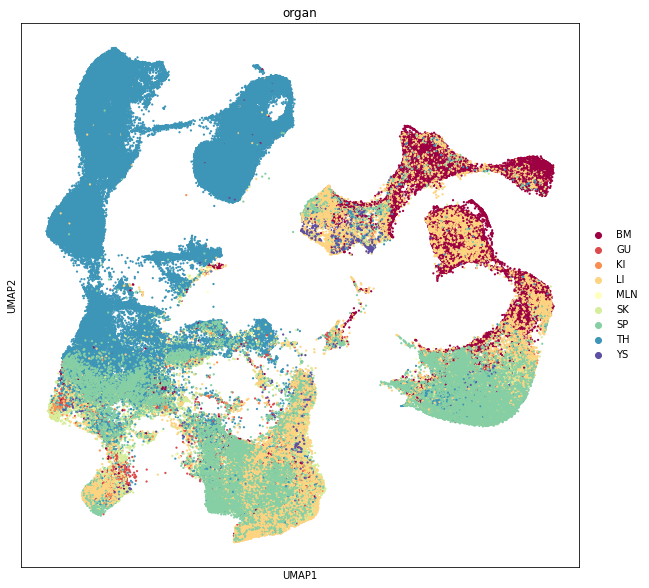

In [11]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color="organ", palette="Spectral", size=20)

In [12]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])

adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

### Load annotations

In [13]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

In [14]:
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()

In [15]:
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

## Accounting for bias in FACS sorting
Load CD45+/- proportions, provided by Isaac

In [16]:
facs_prop_df = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/meta_share/220621_FACs_gating_proportions_correct.csv")

## Keep only CD45+ and CD45- cells
facs_prop_df = facs_prop_df[facs_prop_df["sort.ids"].isin(["CD45+", "CD45-"])]

## Distinguish tissues where there have been multiple sorts by the no of total events 
facs_prop_df["sort_sample_id"] = facs_prop_df.origin + "_" + facs_prop_df["orig.ident"] + "_" + facs_prop_df.total_live_events.astype("str")

## Add to obs and visualize on UMAP
obs_names = adata.obs.index.copy()
new_obs = pd.merge(adata.obs, facs_prop_df, how="left", indicator=True)
new_obs.index = obs_names

adata.obs = new_obs.drop("_merge", 1).copy()

... storing 'Sample.lanes' as categorical
... storing 'anno_lvl_2_final_clean' as categorical
... storing 'orig.ident' as categorical
... storing 'sort.ids' as categorical
... storing 'origin' as categorical
... storing 'count' as categorical
... storing 'total_live_events' as categorical
... storing 'sort_sample_id' as categorical


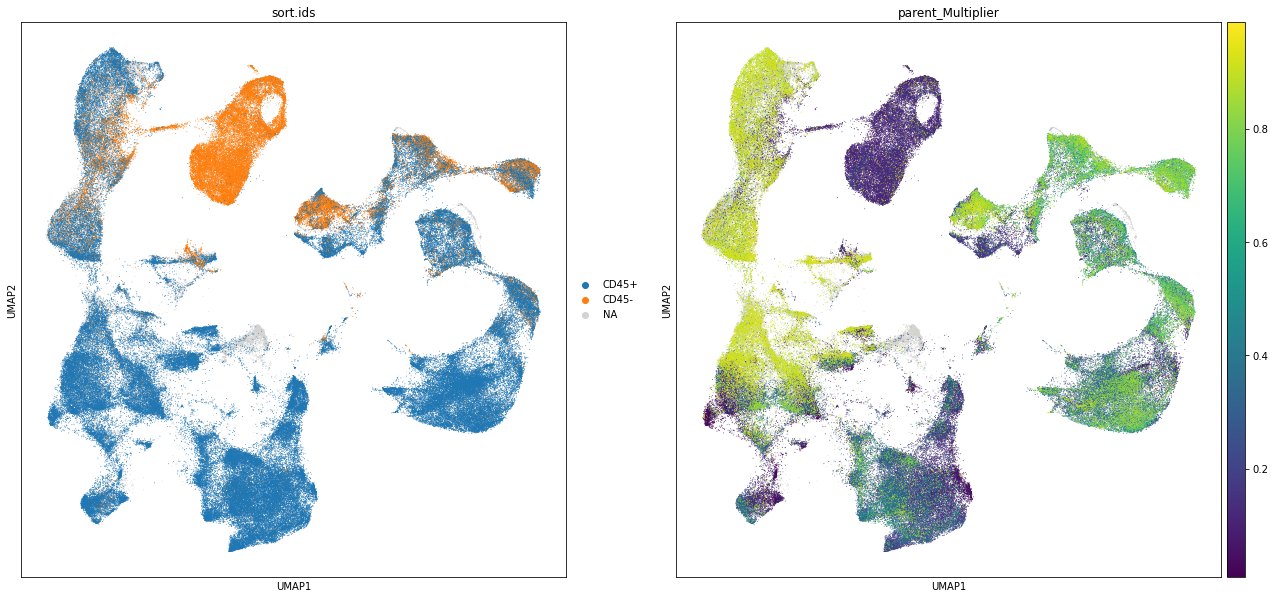

In [17]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["sort.ids","parent_Multiplier"], size=3)

### Pre-processing for differential abundance testing

We bin gestational ages in 6 windows of 2 weeks length.

In [18]:
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']
cut_bins = [0, 8, 10, 12, 14, 16, 18]
adata.obs["age_bins"] = pd.cut(adata.obs["age"], bins=cut_bins, labels=cut_labels_4).astype("str")
adata.obs["age_bins"] = pd.Categorical(adata.obs["age_bins"], categories=cut_labels_4, ordered=True)
adata.obs["age_bins"]

## Convert covariate to continous
adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes

We keep cells sorted for CD45+, CD45- or total.

In [19]:
### Fix sort ids
adata.obs["Sort_id"] = ["CD45P" if x == "CD45P_CD45N" else x for x in adata.obs["Sort_id"]]
adata.obs["Sort_id"] = ["CD45N" if x == "CD45EN" else x for x in adata.obs["Sort_id"]]

### Exclude cells from unconventional sorts
adata = adata[adata.obs["Sort_id"].isin(["CD45P", "CD45N", "TOT"])]
### Exclude CD45P/N cells that don't have true fraction quantification
# (mainly Gut, ask Rasa)
adata = adata[~(adata.obs["Sort_id"].isin(["CD45P", "CD45N"]) & adata.obs["sort.ids"].isna())]

In [20]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

In [21]:
## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

### Calculate correction factor for each sample

We define the correction factor as 

$$ f_{n} = \log \frac{p_n \cdot \sum_n{S_n}}{S_n} $$

where $p_n$ represents the true proportion of cells from sort $n$ in the tissue samples (column `parent_Multiplier` in FACS table), and $S_n$ represents the total number of cells in sort $n$ (of note, this doesn't coincide with the sum of all $c_{n,i}$ since the same cell can be included in multiple neighbourhoods).

For the unsorted samples we set the correction factor to 0.

In [22]:
import milopy
def _add_FACS_correction_factor(adata):
    milopy.utils.add_covariate_to_nhoods_var(adata,["parent_Multiplier", "sort.ids", 'donor', 'sort_sample_id'])
    nhood_adata = adata.uns["nhood_adata"].copy()
    ## Keep only samples with CD45+/CD45- ratio information
    nhood_adata = nhood_adata[:,nhood_adata.var["sort.ids"].isin(["CD45+", "CD45-"])]
    ## Exclude neighbourhoods that are empty after filtering
    nhood_adata = nhood_adata[nhood_adata.X.sum(1) > 0]
    ## Apply correction
    X_counts = nhood_adata.X.toarray()
    adata.obs["n_sort"] = adata.obs["sort_sample_id"].astype("str") + "_" + adata.obs["sort.ids"].astype("str")
    nhood_adata.var["n_sort"] = nhood_adata.var["sort_sample_id"].astype("str") + "_" + nhood_adata.var["sort.ids"].astype("str")
    sum_i_c_n = adata.obs["n_sort"].value_counts()[nhood_adata.var["n_sort"]].values
    p = nhood_adata.var["parent_Multiplier"].astype("float").values
    sum_S = adata.obs["sort_sample_id"].value_counts()[nhood_adata.var["sort_sample_id"]].values
    count_correction_fact = (p * sum_S)/sum_i_c_n
    fact_correction_df = pd.DataFrame([count_correction_fact, nhood_adata.var_names]).T
    
    fact_correction_df.columns = ["correction_factor", "Sample.lanes"]
    new_obs = pd.merge(adata.obs, fact_correction_df,how="left")
    new_obs.index = adata.obs_names
    adata.obs = new_obs.copy()
    adata.obs["correction_factor"]= adata.obs["correction_factor"].astype("float64")
    adata.obs["correction_factor"] = np.log10(adata.obs["correction_factor"])
    return(adata, count_correction_fact)

In [23]:
## Add correction factor
if "correction_factor" in adata.obs.columns:
    adata.obs = adata.obs.drop("correction_factor",1)
    del adata.uns["nhood_adata"].var["correction_factor"]
adata,fact = _add_FACS_correction_factor(adata)
## Set factor to 0 for unsorted samples
adata.obs.loc[adata.obs["Sort_id"]=="TOT","correction_factor"] = 0

Trying to set attribute `.var` of view, copying.


In [24]:
import milopy.core as milo
def _milo_test_by_organ(adata, design="~ Sort_id + age_bins", sample_col="Sample.lanes", test_organs = None):  
    if test_organs is None:
        ## Keep organs covering at least two time-points
        df = adata.obs[["organ",sample_col, "age_bins"]].drop_duplicates()
        df = df.groupby(["organ","age_bins"]).count().reset_index().pivot("organ",columns="age_bins")
        sampled_organs = df.index[(df > 0).sum(1) > 2]
    else:
        sampled_organs = test_organs

    ## Calculate logFC and SpatialFDR within each organ
    milo_res_dict = {}
    for org in sampled_organs:
        print(org)
        org_samples = adata.obs[adata.obs["organ"] == org][sample_col].unique()
        milo.DA_nhoods(adata, design=design, subset_samples=org_samples)
        milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

    ## Collapse results
    logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
    for k,v in milo_res_dict.items():
        milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
        milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

    org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
    org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)
    return(milo_res_dict, org_fc, org_fdr)

In [25]:
milo_res_2, org_fc_2, org_fdr_2 = _milo_test_by_organ(adata, 
                                                      design="~ correction_factor + age_bins",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

BM
LI
SK
SP
TH


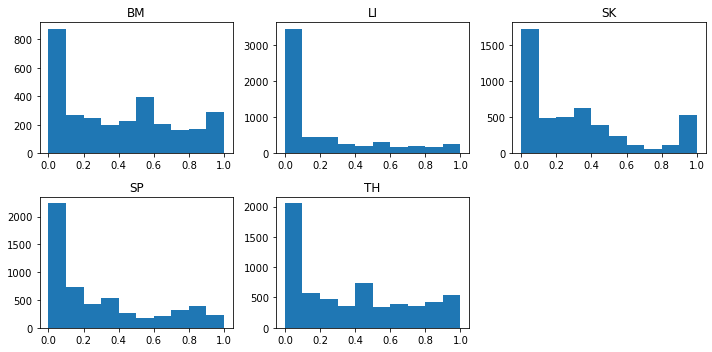

In [26]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.hist(milo_res_2[k].PValue);
    plt.title(k);
    plt.tight_layout();
    i+=1

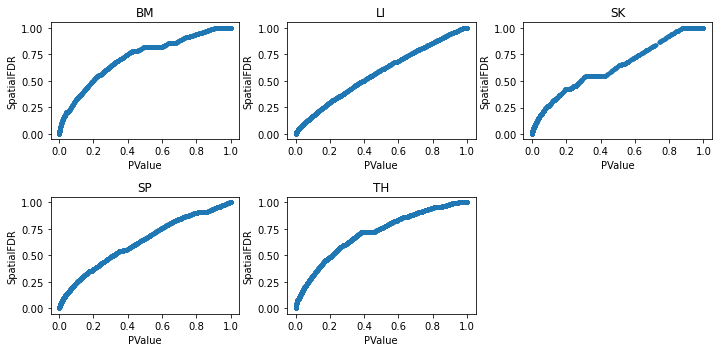

In [27]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.plot(milo_res_2[k].PValue, milo_res_2[k].SpatialFDR, '.');
    plt.title(k);
    plt.tight_layout();
    plt.xlabel("PValue");
    plt.ylabel("SpatialFDR");
    i+=1

In [28]:
## Exclude neighbourhoods where DA is explained by 10X protocol
# (eliminates false positives in the thymus, where there is partial
# confounding between method and age bins)
milo_res_method, org_fc_method, org_fdr_method = _milo_test_by_organ(adata, 
                                                      design="~ method",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

org_fc_filtered_2 = org_fc_2.copy()
org_fdr_filtered_2 = org_fdr_2.copy()
for o in ["BM", "LI", "SK", "SP", "TH"]:
    org_fc_filtered_2["logFC_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan
    org_fdr_filtered_2["SpatialFDR_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan


BM
LI
SK
SP
TH


### Visualize with beeswarm plot

In [29]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

In [43]:
org_fc_filtered = org_fc_filtered_2.copy()

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [44]:
%%R -i org_fc_filtered -i org_fdr_2 -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr_2 %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood  nhood_anno anno_group organ    logFC   SpatialFDR mean_logFC
1  7465 SMALL_PRE_B    B CELLS    BM 2.730718 7.465438e-07   2.730718
2   547 SMALL_PRE_B    B CELLS    BM 2.676428 9.243535e-07   2.676428
3  6847 SMALL_PRE_B    B CELLS    BM 2.508619 7.465438e-07   2.508619
4  6865 SMALL_PRE_B    B CELLS    BM 2.486555 3.145008e-05   2.486555
5 10331       CD8+T NK/T CELLS    SP 2.466513 1.342041e-03   2.466513
6  3510 SMALL_PRE_B    B CELLS    BM 2.464262 2.998007e-06   2.464262


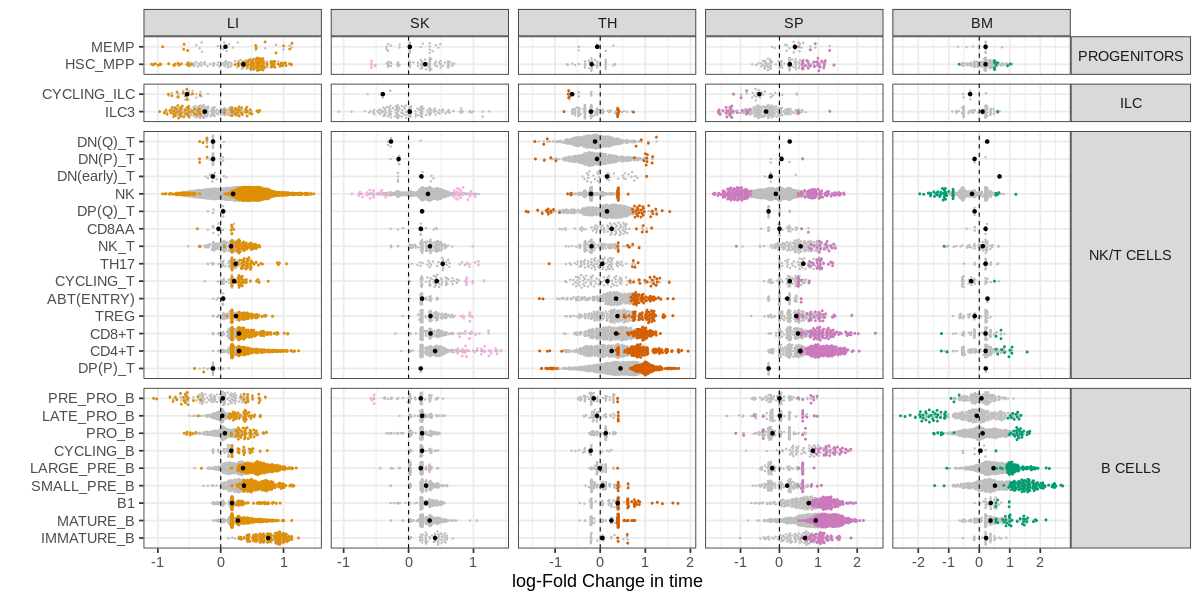

In [46]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c("PROGENITORS", "ERYTHROID CELLS", "ILC", "MYELOID", "NK/T CELLS", "B CELLS")

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "NK/T CELLS", "B CELLS", "ILC"))

alpha=0.1
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
pl1 
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

Visualize distribution in age

In [33]:
# org_count_df = anno_obs.groupby(["organ", "anno_lvl_2_final_clean"]).count()['is_annotated'].reset_index()
# anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
# org_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
# org_count_df.loc[org_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
# org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

In [47]:
anno_obs.loc[adata.obs_names]

n_counts  n_genes            file      mito  \
index                                                                          
FCAImmP7579224-CTAATGGCACTGTGTA   51305.0     5492  FCAImmP7579224  0.046467   
FCAImmP7579224-ATTATCCAGAGAACAG   39999.0     5076  FCAImmP7579224  0.038651   
FCAImmP7579224-GACGGCTAGCCACCTG   38114.0     5282  FCAImmP7579224  0.034633   
FCAImmP7579224-GCGGGTTGTCCGAGTC   33207.0     4690  FCAImmP7579224  0.028247   
FCAImmP7579224-AGTTGGTAGTGTTAGA   31058.0     4591  FCAImmP7579224  0.044433   
...                                   ...      ...             ...       ...   
FCAImmP7277565-GTCAAGTCATAAAGGT    2022.0      808  FCAImmP7277565  0.016320   
FCAImmP7277565-ATCATGGGTAAATGTG    2021.0      847  FCAImmP7277565  0.021771   
FCAImmP7277565-ATTGGTGCACGCTTTC    2013.0      946  FCAImmP7277565  0.022355   
FCAImmP7277565-GAACATCGTACCAGTT    2018.0      913  FCAImmP7277565  0.019822   
FCAImmP7277565-GGCTCGACAGGATTGG    2001.0      864  FCAImmP7277565  0.026487   

                                 doublet_scores predicted_doublets  \
index                                                                
FCAImmP7579224-CTAATGGCACTGTGTA        0.176471              False   
FCAImmP7579224-ATTATCCAGAGAACAG        0.087221              False   
FCAImmP7579224-GACGGCTAGCCACCTG        0.110588              False   
FCAImmP7579224-GCGGGTTGTCCGAGTC        0.133690              False   
FCAImmP7579224-AGTTGGTAGTGTTAGA        0.133690              False   
...                                         ...                ...   
FCAImmP7277565-GTCAAGTCATAAAGGT        0.026087              False   
FCAImmP7277565-ATCATGGGTAAATGTG        0.028971              False   
FCAImmP7277565-ATTGGTGCACGCTTTC        0.016225              False   
FCAImmP7277565-GAACATCGTACCAGTT        0.089376              False   
FCAImmP7277565-GGCTCGACAGGATTGG        0.167095              False   

                                                         name   uniform_label  \
index                                                                           
FCAImmP7579224-CTAATGGCACTGTGTA  FCAImmP7579224_filtered.h5ad             NaN   
FCAImmP7579224-ATTATCCAGAGAACAG  FCAImmP7579224_filtered.h5ad             NaN   
FCAImmP7579224-GACGGCTAGCCACCTG  FCAImmP7579224_filtered.h5ad        LTI/ILC3   
FCAImmP7579224-GCGGGTTGTCCGAGTC  FCAImmP7579224_filtered.h5ad       SP T CELL   
FCAImmP7579224-AGTTGGTAGTGTTAGA  FCAImmP7579224_filtered.h5ad       SP T CELL   
...                                                       ...             ...   
FCAImmP7277565-GTCAAGTCATAAAGGT  FCAImmP7277565_filtered.h5ad       DN T CELL   
FCAImmP7277565-ATCATGGGTAAATGTG  FCAImmP7277565_filtered.h5ad            TREG   
FCAImmP7277565-ATTGGTGCACGCTTTC  FCAImmP7277565_filtered.h5ad       DN T CELL   
FCAImmP7277565-GAACATCGTACCAGTT  FCAImmP7277565_filtered.h5ad  PRE PRO B CELL   
FCAImmP7277565-GGCTCGACAGGATTGG  FCAImmP7277565_filtered.h5ad       DP T CELL   

                                uniform_label_expanded_merged  \
index                                                           
FCAImmP7579224-CTAATGGCACTGTGTA                           NaN   
FCAImmP7579224-ATTATCCAGAGAACAG                           NaN   
FCAImmP7579224-GACGGCTAGCCACCTG                      LTI/ILC3   
FCAImmP7579224-GCGGGTTGTCCGAGTC                     SP T CELL   
FCAImmP7579224-AGTTGGTAGTGTTAGA                     SP T CELL   
...                                                       ...   
FCAImmP7277565-GTCAAGTCATAAAGGT                     DN T CELL   
FCAImmP7277565-ATCATGGGTAAATGTG                          TREG   
FCAImmP7277565-ATTGGTGCACGCTTTC                     DN T CELL   
FCAImmP7277565-GAACATCGTACCAGTT                PRE PRO B CELL   
FCAImmP7277565-GGCTCGACAGGATTGG                     DP T CELL   

                                uniform_label_lvl0  ...    Sample.lanes  \
index                                               ...                   
FCAImmP7579224-CTAATGGCACTGTGTA

In [48]:
org_colors = pd.read_csv("../../metadata/organ_colors.csv", index_col=0)

age_count_df = anno_obs.loc[adata.obs_names].groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
age_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df.loc[age_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

In [49]:
age_count_df

age anno_lvl_2_final_clean  file       anno_group          anno
0      4                  CD4+T     2       NK/T CELLS         CD4+T
1      4                    CMP    28      PROGENITORS           CMP
2      4            CYCLING_DC2    12          MYELOID   CYCLING_DC2
3      4            CYCLING_PDC     1          MYELOID   CYCLING_PDC
4      4                    DC1     2          MYELOID           DC1
..   ...                    ...   ...              ...           ...
438   17           PROMYELOCYTE     2  ERYTHROID CELLS  PROMYELOCYTE
439   17                  PRO_B  1129          B CELLS         PRO_B
440   17            SMALL_PRE_B  2389          B CELLS   SMALL_PRE_B
441   17                   TH17   282       NK/T CELLS          TH17
442   17                   TREG   838       NK/T CELLS          TREG

[443 rows x 5 columns]

In [51]:
%%R -i age_count_df --i figdir -w 800 -h 1000
anno_order <- unique(as.character(pl1$data$nhood_anno))

age_pl_df <- age_count_df %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(anno=factor(anno, levels=anno_order)) %>%
    filter(!is.na(anno)) %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "NK/T CELLS", "B CELLS", "ILC"))
   
    
pl2 <- age_pl_df %>%
    mutate(grid='') %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~grid, space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=18) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.3) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 
#     ggsave(paste0(figdir, "age_distribution.pdf"), height=16, width=12) +
#     ggsave(paste0(figdir, "age_distribution.png"), height=16, width=12) 

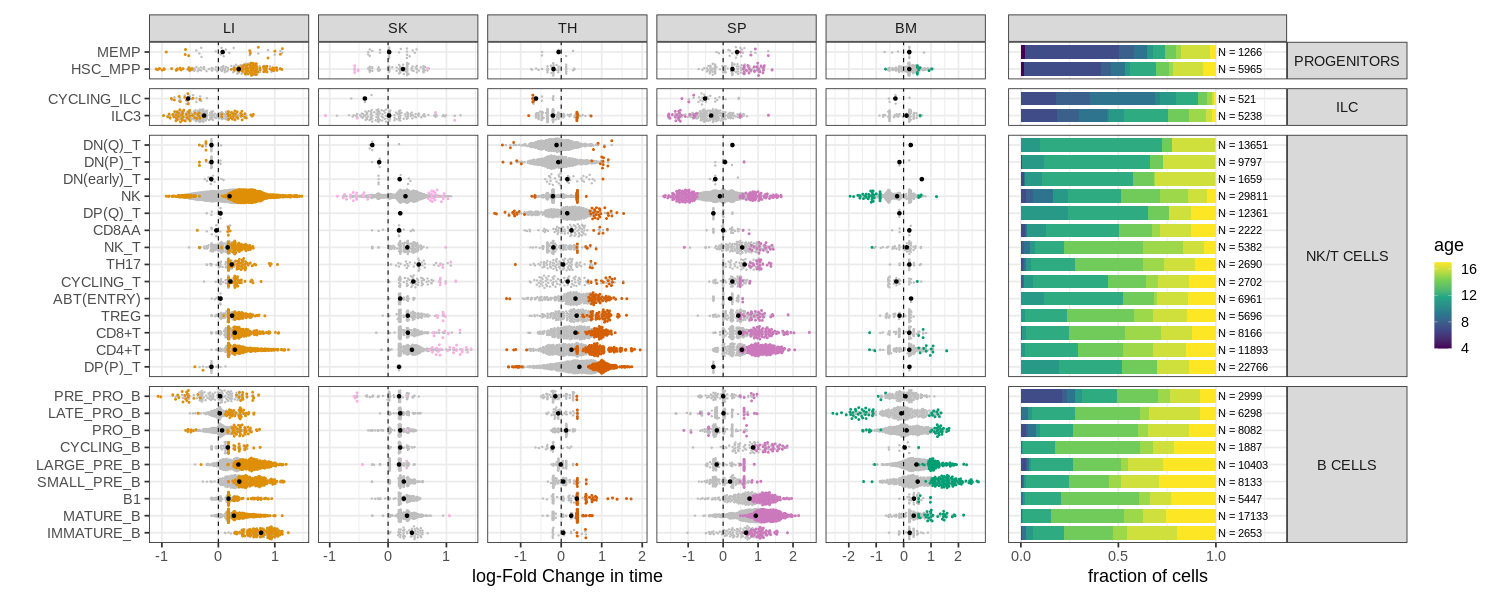

In [52]:
%%R -w 1500 -h 600
(pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) +
(pl2 + remove_y_axis()) +
plot_layout(widths=c(3,1)) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=25, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=25, height=10)

In [53]:
org_age_range  = anno_obs.loc[adata.obs_names][['organ', "age"]].drop_duplicates()

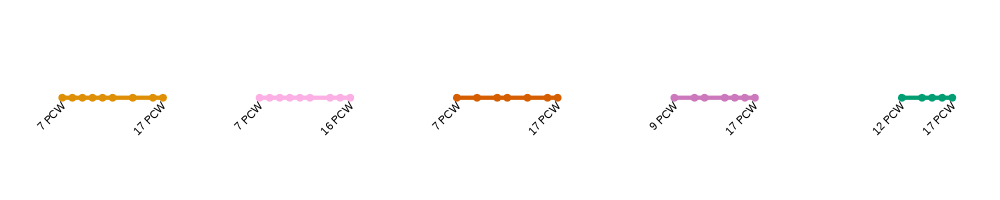

In [54]:
%%R -i org_age_range -w 1000 -h 200
organ_ord <- c("LI", "SK", "TH", "SP", "BM")
p3 <- org_age_range %>%
    filter(organ %in% organ_ord) %>%
    mutate(organ=factor(organ, levels=organ_ord)) %>%
    group_by(organ) %>%
    mutate(max_age=paste0(max(age), " PCW"), 
           min_age=paste0(min(age), " PCW")) %>%
    mutate(y=1) %>%
    ggplot(aes( age, y, color=organ)) +
    geom_point(size=3) +
    geom_line(size=2) +
    geom_text(data=. %>% group_by(organ) %>% filter(age==min(age)), 
              aes(label=min_age), angle=45,
              vjust = 1.2, 
              hjust = 1.1, nudge_x = -0.05, color='black') +
    geom_text(data=. %>% group_by(organ) %>% filter(age==max(age)), 
              aes(label=max_age), angle=45,
              vjust = 1.2,  
              hjust = 1.1, nudge_x = -0.05, color='black') +
    facet_grid(.~organ) +
    scale_color_manual(values=organ_palette) +
    theme_classic(base_size=18) +
     expand_limits(x = c(3,20)) +
    remove_y_axis() + remove_x_axis() + 
    guides(color='none') +
    xlab("") + ylab("log-Fold Change in time") +
    theme(strip.text.y=element_text(angle=0), axis.line=element_blank(), 
          strip.background=element_blank(), strip.text=element_blank())
p3

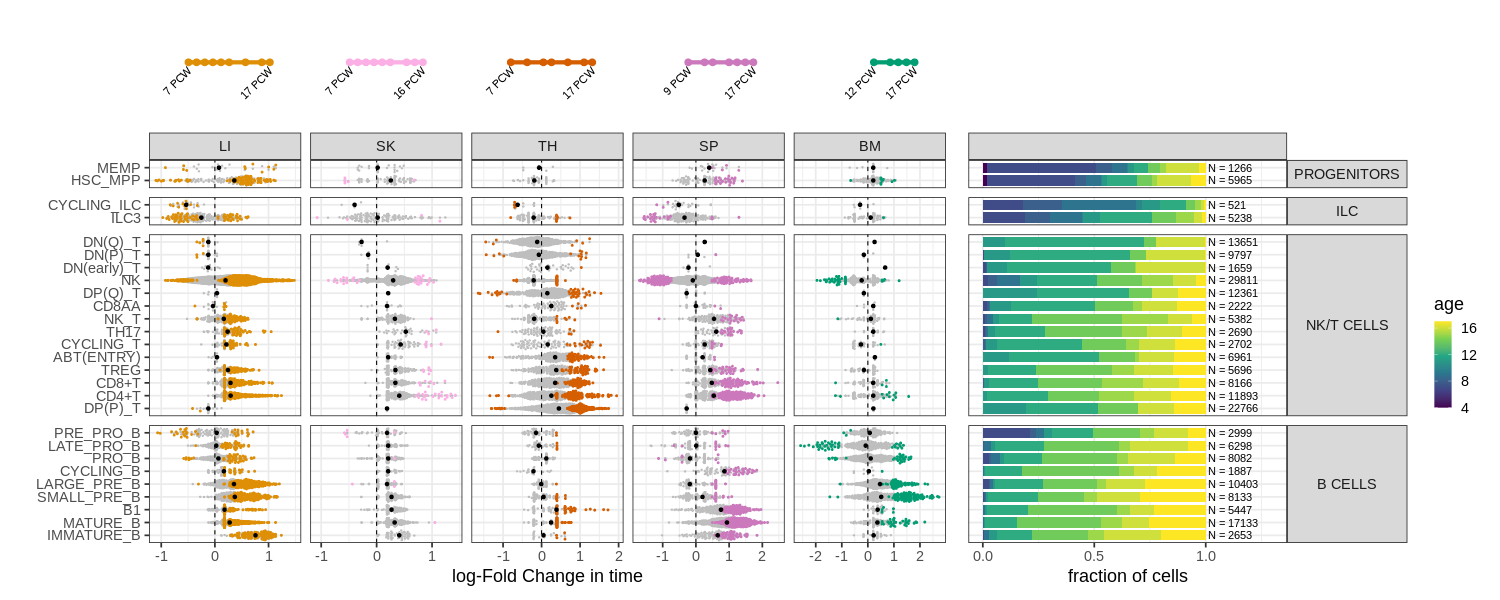

In [55]:
%%R -w 1500 -h 600
layout <- "
AAAAA##
BBBBBCC
BBBBBCC
BBBBBCC
BBBBBCC
"

(p3 + 
 (pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) + 
 (pl2 + remove_y_axis())) +
plot_layout(design=layout) +
# ((p3 / (pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) +
#      plot_layout(heights=c(1,10)) 
#  ) |
# (plot_spacer() / pl2 + remove_y_axis()) + plot_layout(heights=c(1,10)) ) +
# plot_layout(widths=c(3,1)) 
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=25, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=25, height=10)

### Visualize on UMAP

In [56]:
milopy.utils.build_nhood_graph(adata)

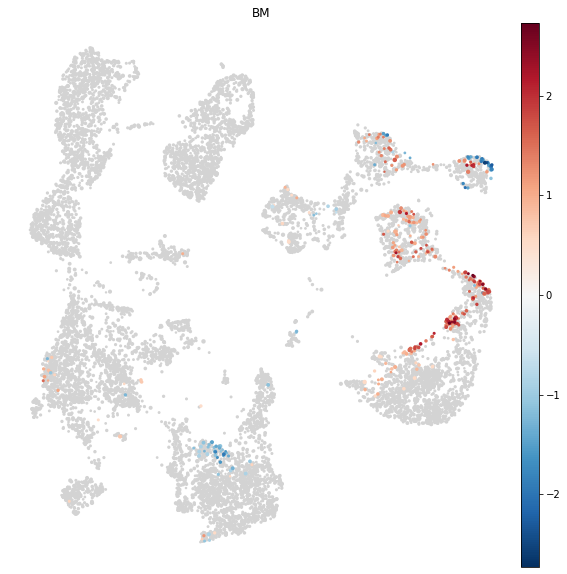

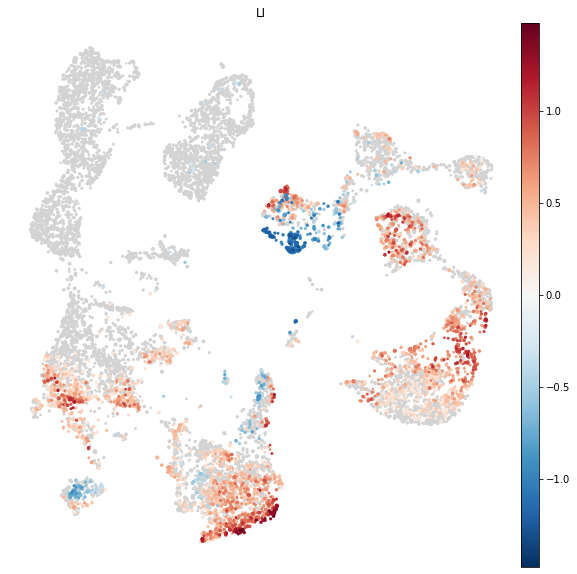

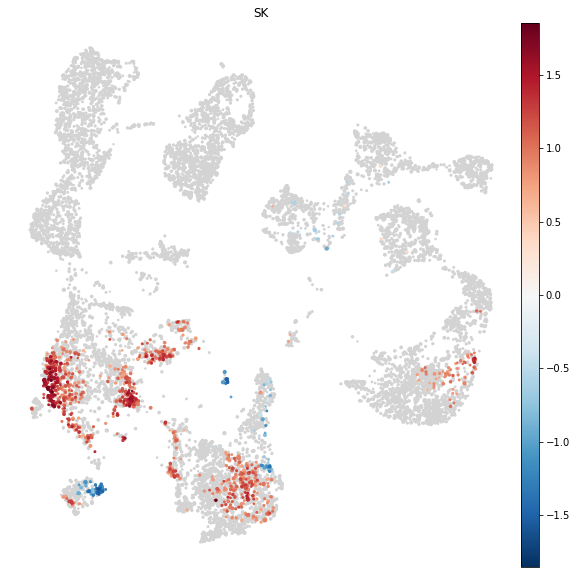

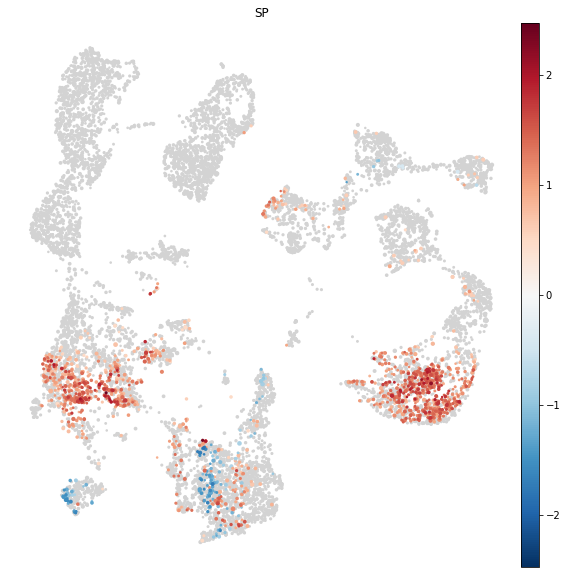

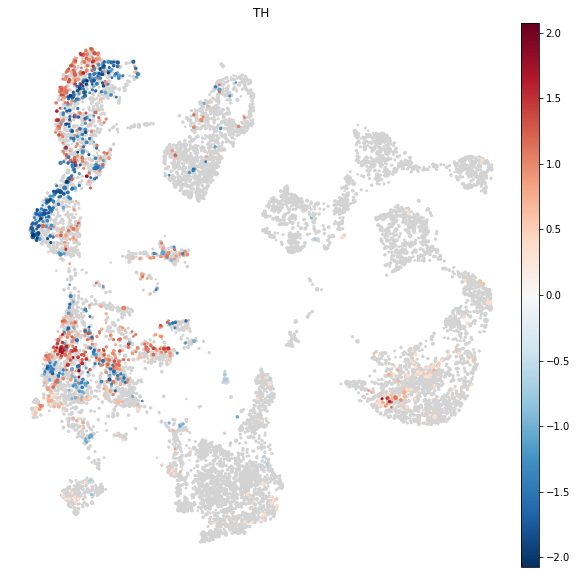

In [57]:
test_organs = ["BM", "LI", "SK", "SP", "TH"]
plt.rcParams['figure.figsize'] = [10,10]
for i in range(len(test_organs)):
    adata.uns["nhood_adata"].obs = milo_res_2[test_organs[i]].copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopy.plot.plot_nhood_graph(adata, min_size=1, title=test_organs[i], save="milo_nhoods_graph_{o}.png".format(o=test_organs[i]),
                )


---
---
### Visualize with beeswarm plot

In [29]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

In [48]:
anno_groups_dict["NK/T CELLS"]

['CYCLING_T',
 'CD4+T',
 'CD8+T',
 'TREG',
 'NK',
 'CYCLING_NK',
 'NK_T',
 'DP(P)_T',
 'TH17',
 'CD8AA',
 'ABT(ENTRY)',
 'DP(Q)_T',
 'DN(P)_T',
 'DN(early)_T',
 'DN(Q)_T']

In [30]:
org_fc_filtered = org_fc_filtered_2.copy()

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [49]:
%%R -i org_fc_filtered -i org_fdr_2 -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr_2 %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood  nhood_anno anno_group organ    logFC   SpatialFDR mean_logFC
1  7465 SMALL_PRE_B    B CELLS    BM 2.730718 7.465438e-07   2.730718
2   547 SMALL_PRE_B    B CELLS    BM 2.676428 9.243535e-07   2.676428
3  6847 SMALL_PRE_B    B CELLS    BM 2.508619 7.465438e-07   2.508619
4  6865 SMALL_PRE_B    B CELLS    BM 2.486555 3.145008e-05   2.486555
5 10331       CD8+T NK/T CELLS    SP 2.466513 1.342041e-03   2.466513
6  3510 SMALL_PRE_B    B CELLS    BM 2.464262 2.998007e-06   2.464262


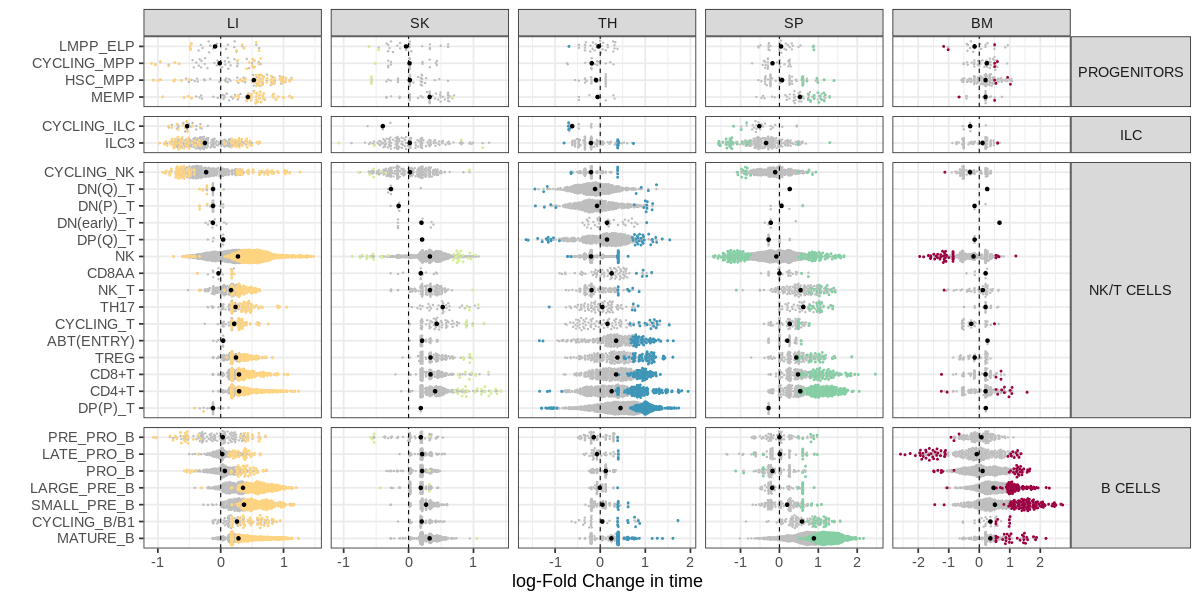

In [50]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c("PROGENITORS", "ERYTHROID CELLS", "ILC", "MYELOID", "NK/T CELLS", "B CELLS")

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "ILC", "NK/T CELLS", "B CELLS"))

alpha=0.1
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
pl1 
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

Visualize distribution in age

In [51]:
# org_count_df = anno_obs.groupby(["organ", "anno_lvl_2_final_clean"]).count()['is_annotated'].reset_index()
# anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
# org_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
# org_count_df.loc[org_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
# org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

In [52]:
org_colors = pd.read_csv("../../metadata/organ_colors.csv", index_col=0)

age_count_df = anno_obs.loc[adata.obs_names].groupby(["age", "anno_lvl_2_final_clean"]).count()['is_annotated'].reset_index()
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
age_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df.loc[age_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

In [53]:
%%R -i age_count_df --i figdir -w 800 -h 1000
anno_order <- unique(as.character(pl1$data$nhood_anno))

age_pl_df <- age_count_df %>%
    rename(N_cells = is_annotated) %>%
    group_by(anno) %>%
    mutate(anno=factor(anno, levels=anno_order)) %>%
    filter(!is.na(anno)) %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "ILC", "NK/T CELLS", "B CELLS"))
   
    
pl2 <- age_pl_df %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=14) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.3) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 
#     ggsave(paste0(figdir, "age_distribution.pdf"), height=16, width=12) +
#     ggsave(paste0(figdir, "age_distribution.png"), height=16, width=12) 

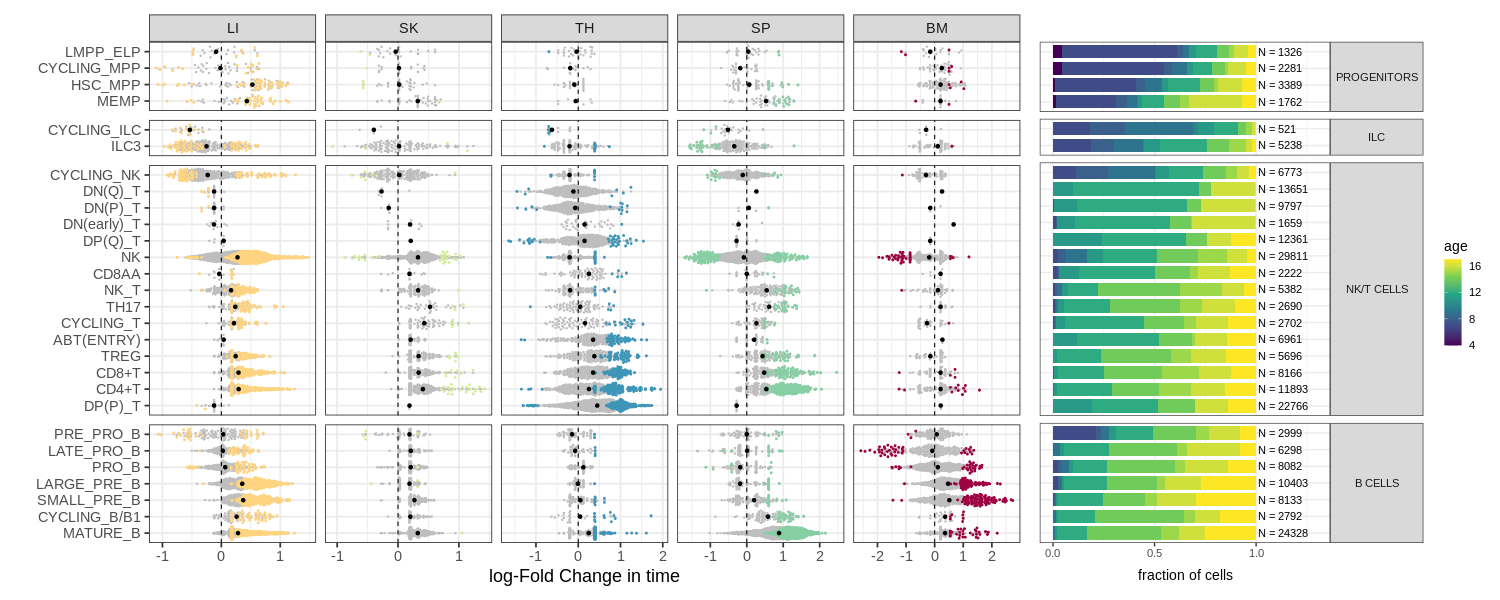

In [54]:
%%R -w 1500 -h 600
(pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) +
(pl2 + remove_y_axis()) +
plot_layout(widths=c(3,1)) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=25, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=25, height=10)

### Visualize on UMAP

In [41]:
milopy.utils.build_nhood_graph(adata)

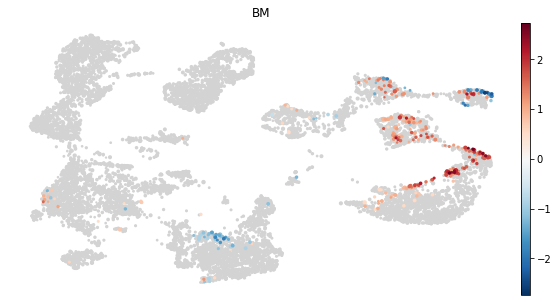

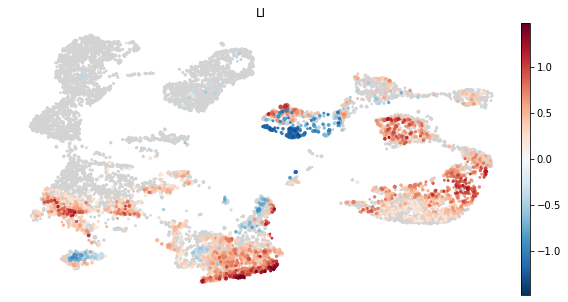

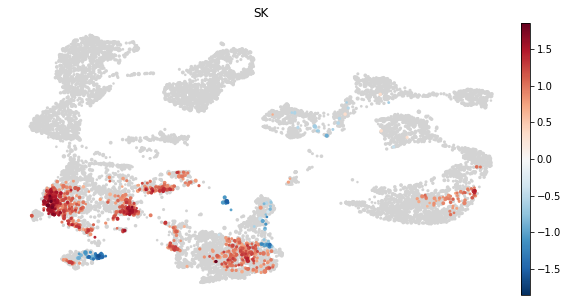

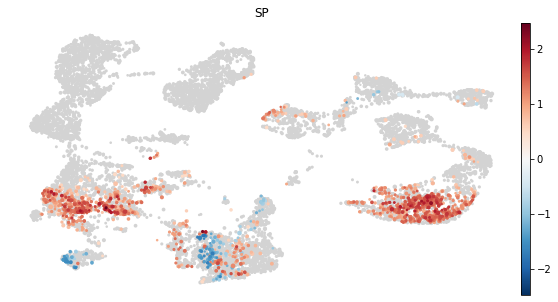

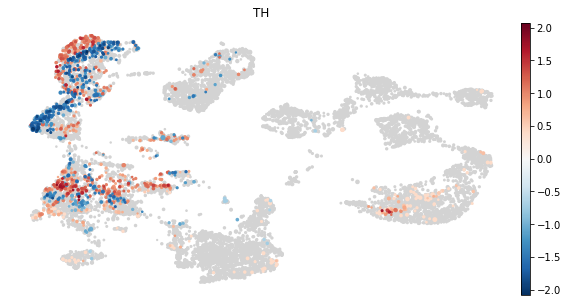

In [42]:
test_organs = ["BM", "LI", "SK", "SP", "TH"]
for i in range(len(test_organs)):
    adata.uns["nhood_adata"].obs = milo_res_2[test_organs[i]].copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopy.plot.plot_nhood_graph(adata, min_size=1, title=test_organs[i])


### Save processed outputs

In [58]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Save dataframe for beeswarm plot
pl_df.to_csv(outdir + "milo_beeswarm_plot_data.{s}.csv".format(s=split))

## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
adata.obs.drop("remarks", axis=1, inplace=True)
del adata.uns["nhood_adata"]
adata.write_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

In [69]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)

In [70]:
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))

--- Logging error ---
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, i

In [71]:
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

In [72]:
long_org_fc = pd.read_csv(outdir + "milo_beeswarm_plot_data.{s}.csv".format(s=split), index_col=0)

In [73]:
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']

### Differential expression analysis

Calculate mean expression for each neighbourhood

In [148]:
## Add mean expression for each neighbourhood
nhood_adata = adata.uns["nhood_adata"].copy()
X = adata.X
expr_id = "expr" 
## Aggregate over nhoods -- taking the mean
nhoods_X = X.T.dot(adata.obsm["nhoods"])

from scipy.sparse import csr_matrix
nhoods_X = csr_matrix(nhoods_X / adata.obsm["nhoods"].toarray().sum(0))
adata.uns["nhood_adata"].obsm[expr_id] = nhoods_X.T

Label neighbourhoods by outcome in each organ test

In [149]:
# long_org_fc = pl_df.copy()
alpha=0.1

In [150]:
signif_early = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] < 0)
signif_late = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] > 0)
not_signif = (long_org_fc['SpatialFDR'] >= alpha)

long_org_fc['test_label'] = "not_signif"
long_org_fc.loc[signif_late, "test_label"] = "signif_late"
long_org_fc.loc[signif_early, "test_label"] = "signif_early"

In [112]:
def test_DGE(adata, long_org_fc, subset_organ, subset_anno, alpha=0.1, 
             condition='signif_late', test_type='vs_rest',
                max_frac = 0.8
            ):
    '''
    Extract cells in neighbourhoods with significant enrichment in early or late cells and use 
    simple scanpy test to find markers VS the rest of cells in the same organ/annotation.
    
    Params:
    -------
    - long_org_fc: long format dataframe containing milo testing results
    - subset_organ: list of organs to test in
    - subset_anno: list or cell types to test in (values or `anno_lvl_2_final_clean`)
    - alpha: significance FDR threshold (default=0.1)
    - condition: which condition to compare to the rest? (either `signif_late` or `signif_early`)
    - test_type: 'vs_rest' condition VS all other cells, 'vs_opposite' condition VS opposite condition
    - max_frac: exclude genes that are expressed in more than this fraction of cells in all age bins 
    (to exclude very highly expressed genes in all the cluster)
    '''
    keep_nhoods_df = long_org_fc[(long_org_fc.organ.isin(subset_organ)) & (long_org_fc.nhood_anno.isin(subset_anno))][["Nhood", "test_label"]]
    pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == condition]["Nhood"].astype('int')

    cells_in_nhoods = adata.obsm["nhoods"][:,pick_nhoods].toarray().sum(1) > 0
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))

    test_adata = adata[cells_in_org]
    
    ## Define case VS control
    case_cells = adata[cells_in_org & cells_in_nhoods].obs_names
    if test_type == "vs_rest":
        test_adata.obs["test_condition"] = 'control'
        test_adata.obs.loc[case_cells, "test_condition"] = 'case'
    elif test_type == 'vs_opposite':
        test_adata.obs["test_condition"] = np.nan
        all_conditions = ['signif_early', 'signif_late']
        opposite_condition = [x for x in all_conditions if x != condition][0]
        opposite_pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == opposite_condition]["Nhood"].astype('int')
        opposite_cells_in_nhoods = adata.obsm["nhoods"][:,opposite_pick_nhoods].toarray().sum(1) > 0
        opposite_case_cells = adata[cells_in_org & opposite_cells_in_nhoods].obs_names
        test_adata.obs.loc[opposite_case_cells, "test_condition"] = 'control'
        test_adata.obs.loc[case_cells, "test_condition"] = 'case'
        
    ## Filter genes that are highly expressed everywhere
    high_x = np.empty(shape=(test_adata.n_vars,1))
    for b in test_adata.obs['age_bins'].unique():
        X_bin = test_adata[test_adata.obs['age_bins']==b].X
        nonz_X_bin = X_bin != 0
        top_n_cells = np.round(nonz_X_bin.shape[0]*max_frac)
        high_x_b = np.array(nonz_X_bin.sum(0)).ravel() >= top_n_cells
        high_x = np.hstack([high_x, high_x_b.reshape((test_adata.n_vars,1))])

    high_x =high_x[:,1:]
    keep_vars = test_adata.var_names[np.where(high_x.sum(1) < high_x.shape[1])[0]]
    test_adata = test_adata[:,test_adata.var_names.isin(keep_vars)]

#     if len(case_cells) < 10:
    sc.tl.rank_genes_groups(test_adata, groupby="test_condition", groups=["case"], reference="control")
    
    ## Get dataframe of results
    dge_dict = test_adata.uns['rank_genes_groups'].copy()
    dge_dict.pop("params")
    dge_dict = {k:[x[0] for x in dge_dict[k]] for k,v in dge_dict.items()}
    dge_df = pd.DataFrame.from_dict(dge_dict)
    
    return(test_adata, dge_df)

def get_top_DEGs(dge_df, FC_direction = None, n_genes=30, min_fc=None, alpha=0.001):
    ## Extract top genes and order by FC
    dge_df = dge_df[dge_df['pvals_adj'] < alpha]
    dge_df['abs_logfoldchanges'] = np.abs(dge_df['logfoldchanges'])
    ## Filter out very large lfc (see glmGamPoi docs)
    dge_df = dge_df[dge_df['abs_logfoldchanges'] < 10]
    genes_df = dge_df.sort_values("abs_logfoldchanges", ascending=False)
#     genes_df = dge_df.sort_values("pvals_adj")
    if min_fc is not None:
        genes_df = genes_df[np.abs(genes_df.logfoldchanges) > min_fc]
    if FC_direction is not None:
        genes_df = genes_df[np.sign(genes_df.logfoldchanges) == FC_direction]
    genes = genes_df.iloc[0:n_genes].sort_values("logfoldchanges", ascending=False).names.values
    return(genes)

def plot_DGE(test_adata, dge_df, subset_organ, subset_anno, FC_direction = None,  min_fc=0.1, n_genes=30, figsize=[4,10], save=False, **kwargs):
    ## Extract top genes and order by FC
    genes = get_top_DEGs(dge_df, FC_direction = FC_direction, n_genes=n_genes,  min_fc=None)
  
    #     genes_dict = {}
    #     genes_dict["down"] = genes_df[genes_df["logfoldchanges"] < 0]['names'].values
    #     genes_dict["up"] = genes_df[genes_df["logfoldchanges"] > 0]['names'].values
    
    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
    pl_title = ''.join(subset_anno) + " - " + ''.join(subset_organ) 
    ax = sc.pl.dotplot(test_adata, genes, groupby='age_bins', dendrogram=False, cmap="Reds", 
#                          standard_scale="var",
                         return_fig=False, title=pl_title, swap_axes=True, show=False, 
                               figsize=figsize , **kwargs
                        );
    fig = plt.gcf()
    plot_ax = fig.axes[1]
    cbar_ax = fig.axes[-1]
    cbar_ax.set_title("Median\nexpression");
    bins_labels = dict(zip([str(x) for x in range(len(cut_labels_4))], cut_labels_4))
    plot_ax.set_xticklabels([bins_labels[x.get_text()] for x in plot_ax.get_xticklabels()], 
                            rotation=45, ha="right");
    if save:
        fig.savefig(figdir + pl_title + '_stacked_violin.png', bbox_inches="tight")

In [113]:
def anndata2pseudobulk(adata, group_by, agg="s", min_ncells = 10):
    '''
    Params:
    ------
    adata: the anndata object
    group_by: list of obs columns to use for aggregation
    agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts), 'n' for n expressing
    min_ncells: minimum number of cells to keep pseudobulk sample (default=10)
    '''
    from scipy.sparse import csr_matrix
    import anndata
    if agg=="s" and "log1p" in adata.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Check that pseudobulk profiles are the sum of all profiles in a sample
    a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
    b = pseudobulk_X[:,0].toarray().flatten()
    if not np.all(a == b):
        print("Error! Aggregation doesn't coincide with sum across the same sample")
        return()
    if agg=="m":
        pseudobulk_X = csr_matrix(pseudobulk_X / sample_dummies.toarray().sum(0))
    if agg=='n':
        adata.X[adata.X != 0] = 1
        pseudobulk_X = adata.X.T.dot(sample_dummies)
        ## Check that pseudobulk profiles are the sum of all profiles in a sample
        a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
        b = pseudobulk_X[:,0].toarray().flatten()
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells]

    return(pseudobulk_adata)

In [63]:
%%R -i genes

all(genes %in% highlight_genes) 


Error in genes %in% highlight_genes : object 'highlight_genes' not found


In [183]:
%%R -i cut_labels_4 -w 1000 -h 700
plot_time_highlight <- function(X_pl_df, N_pl_df, genes, highlight_genes
#                                 mean_gex_limits=c(-3,3)
                               ){

    pl_df <- left_join(
        X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
        N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
        ) %>%
        mutate(gene=factor(gene, levels=rev(genes))) %>%
        group_by(gene) %>%
#         group_by(gene, organ) %>%
        mutate(mean_gex=scale(mean_gex, scale=TRUE, center=TRUE)) %>%
#         mutate(mean_gex=(mean_gex - min(mean_gex))/(max(mean_gex) - min(mean_gex))) %>%
        mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
        mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
        mutate(organ = factor(organ, levels=c("YS", "LI","BM",  "TH", "SP",  "SK", "MLN", "KI", "GU"))) 
    
    pl1 <- pl_df %>%
       ggplot(aes( age_bins, gene)) +
        geom_tile(aes(fill=mean_gex)) +
        facet_grid(.~organ, space="free", scales="free") +
#         scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression', limits=mean_gex_limits) +
        scale_fill_distiller(palette='RdBu', name='Mean expression', 
#                              limits=mean_gex_limits
                            ) +
        guides(fill=guide_colorbar()) +
        ylab("DEGs") + xlab("Age bins") +
        theme_classic(base_size=16) +
        theme(axis.text.x=element_text(angle=45, hjust=1), 
#               axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
             )
    
    if (!all(genes %in% highlight_genes) ){
        highlight_df <- data.frame(gene=genes, organ='') %>%
            mutate(highlight=ifelse(gene %in% highlight_genes, gene, NA))

        highlight_pl <- pl_df %>%
            full_join(highlight_df) %>%
            mutate(gene=factor(gene, levels=levels(pl_df$gene))) %>%
            ggplot(aes(1, gene)) +
            ggrepel::geom_text_repel(data=. %>% filter(organ==""), aes(label=highlight),
                                     size=5,
                                      xlim = c(0.7,0.9), direction = "y", hjust = "left",
                                    min.segment.length=0) +
            scale_x_continuous(expand=expansion(mult = c(0.3,0))) +
            cowplot::theme_nothing() +
                    theme(plot.margin=margin(0, 0, 0, 0, "cm"))
        pl1 <- pl1 + 
                remove_y_axis() +
                    theme(axis.text.x=element_text(angle=45, hjust=1), 
    #               axis.text.y=element_blank(), axis.ticks.y=element_blank(),
    #               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
                 )

        (highlight_pl | pl1) +
            plot_layout(widths=c(1,3)) 
    } else {
        pl1
    }
}

#### NK cells

In [145]:
query_sets = [
    (["NK"],["SP", "LI", "SK", "BM", "TH"], "signif_early"), 
    (["NK"],["SP", "LI", "SK", "BM", "TH"], "signif_late"), 
    (["NK"],["SP", "BM"], "signif_early"), 
]

In [192]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


In [195]:
genes_up = get_top_DEGs(dge_df, FC_direction = 1, n_genes=100,  min_fc=0.25)
# genes_down = get_top_DEGs(dge_df, FC_direction = -1, n_genes=500,  min_fc=0.25)

In [526]:
# genes_down = dge_df[(dge_df['pvals_adj'] < 0.01) & (dge_df['logfoldchanges'] < -0.25)]['names'].values

In [539]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


In [540]:
genes_down = get_top_DEGs(dge_df, FC_direction = 1, n_genes=100,  min_fc=0.25)
# genes_down = get_top_DEGs(dge_df, FC_direction = -1, n_genes=100,  min_fc=0.25)

In [541]:
## Save DEG table
df = pd.DataFrame(genes_up, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}_late.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [542]:
df = pd.DataFrame(genes_down, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}_early.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [179]:
genes = genes_up.copy()
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [180]:
## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

In [184]:
%%R -i  X_pl_df -i N_pl_df -i ordered_genes
gex_lims <- c(-2, 2)
p1_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes)
p1_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, sample(ordered_genes, 10))

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


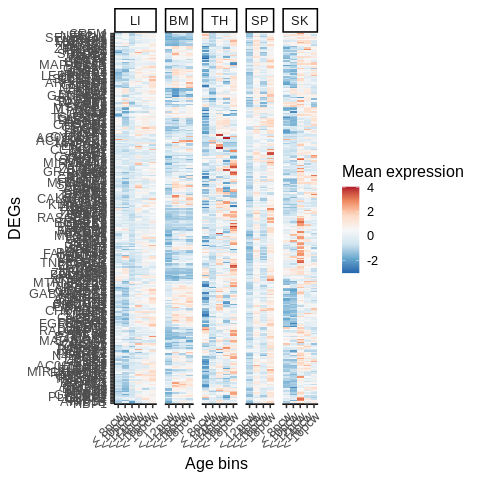

In [185]:
%%R 
p1_all

In [186]:
genes = genes_down.copy()
## mean expression
X_df_ls = []
for org in ["SP", "LI", "SK", "BM", "TH"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SP", "LI", "SK", "BM", "TH"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [188]:
## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
# scaled_df = (df.T - df.mean(1))/df.std(1)
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

In [189]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes
p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes)

Joining, by = c("n_cells", "organ", "age_bins", "gene")


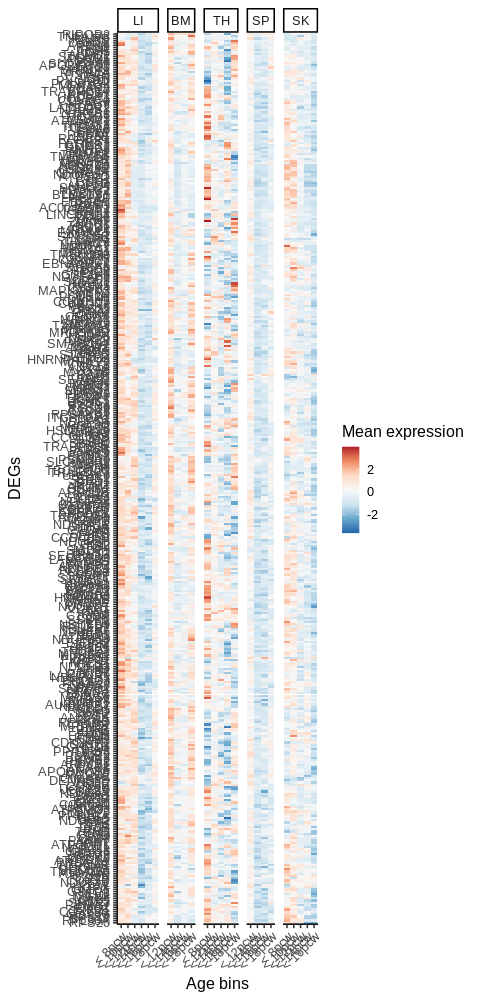

In [191]:
%%R -h 1000
p2_all

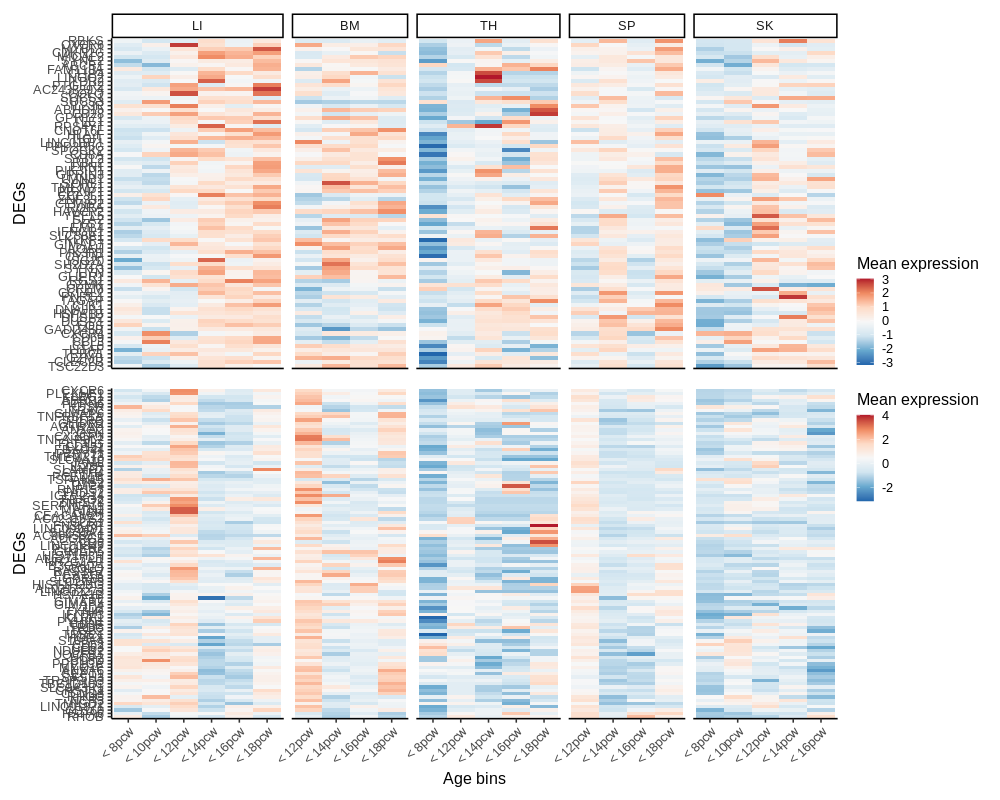

In [577]:
%%R -w 1000 -h 800
((p1_all + remove_x_axis()) / (p2_all + theme(strip.background=element_blank(), strip.text=element_blank(),))) + 
plot_layout(guides="collect") +
 ggsave(paste0(figdir, "NK_cells_DEGs.png"), width=12, height=28) + 
    ggsave(paste0(figdir, "NK_cells_DEGs.pdf"), width=12, height=28) 

#### ILC3 cells

In [427]:
query_sets = [
    (["ILC3"],["SP", "LI", "SK", "BM", "TH"], "signif_early"), 
    (["ILC3"],["SP", "LI", "SK", "BM", "TH"], "signif_late"), 
]

In [428]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


In [302]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)

## mean expression
X_df_ls = []
for org in ["SP", "LI", "SK", "BM", "TH"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SP", "LI", "SK", "BM", "TH"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
# scaled_df = (df.T - df.mean(1))/df.std(1)
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

In [303]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}_early.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [304]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes
p1_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes)
p1_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, sample(ordered_genes, 10))

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


In [305]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


In [306]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in ["SP", "LI", "SK", "BM", "TH"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SP", "LI", "SK", "BM", "TH"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
# scaled_df = (df.T - df.mean(1))/df.std(1)
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [307]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}_late.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [308]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes
p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes)
p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, sample(ordered_genes, 10))

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


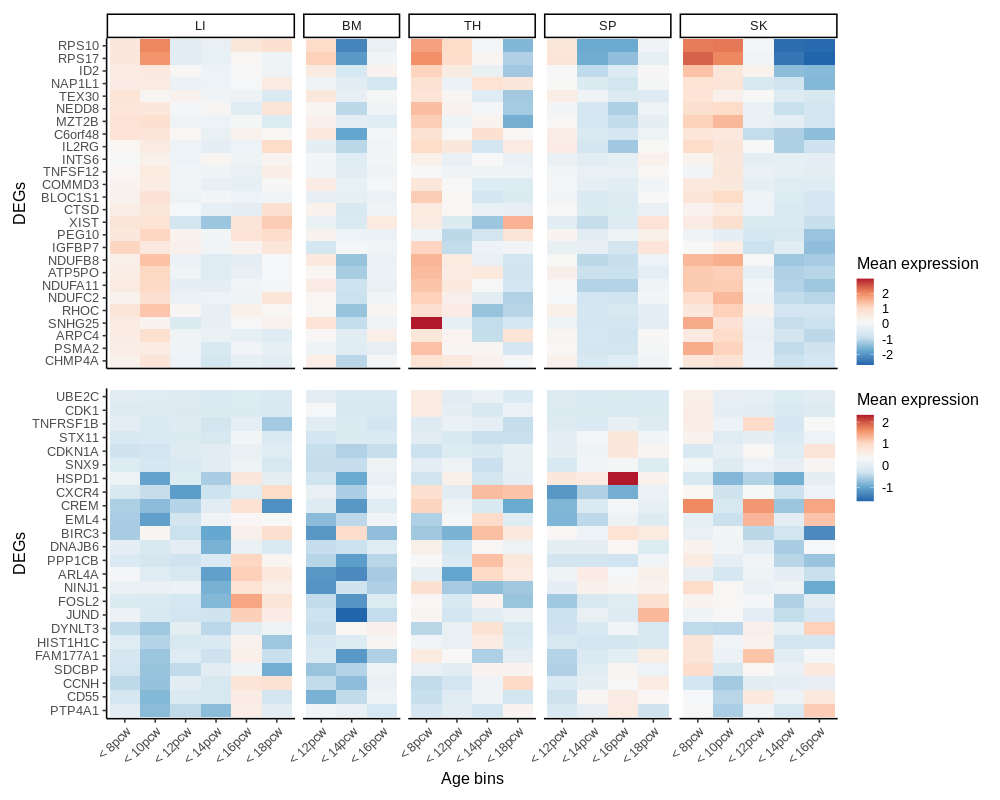

In [309]:
%%R -w 1000 -h 800
((p1_all + remove_x_axis()) / (p2_all + theme(strip.background=element_blank(), strip.text=element_blank(),))) + plot_layout(guides="collect") +
 ggsave(paste0(figdir, "ILC3_cells_DEGs.png"), width=10, height=15) + 
    ggsave(paste0(figdir, "ILC3_cells_DEGs.pdf"), width=10, height=15) 

### Enrichment analysis

In [310]:
# pip install gseapy

In [167]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
# %load_ext autoreload
# %autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

In [172]:
gp.__version__

'0.10.5'

In [174]:
names = gp.get_library_name() # default: Human
names

--- Logging error ---
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, i

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'DisGeNET',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbati

In [171]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True
for gene_sets in ['GO_Biological_Process_2021', "MSigDB_Hallmark_2020"]:
    for infile in [x for x in os.listdir(outdir) if x.startswith("DEG")]:
        id_name = infile.split(".csv")[0]
        DGE = pd.read_csv(outdir+infile) 
        gene_list = list(DGE['DEG'])
        # list, dataframe, series inputs are supported
        enr = gp.enrichr(gene_list=gene_list,
                         gene_sets=gene_sets,
                         organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                         description=id_name,
                         outdir='enrichr/'+id_name+'/',
                         # no_plot=True,
                         cutoff=0.5 # test dataset, use lower value from range(0,1)
                        )
        # to save your figure, make sure that ``ofname`` is not Nonea
        ax=dotplot(enr.res2d, title=gene_sets[0],cmap='RdYlBu_r',cutoff=1, top_terms=10,
                   figsize=(6,6),
                   ofname=figdir + id_name + '.enrichr.pdf')

--- Logging error ---
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, i

KeyboardInterrupt: 

### Plot signatures in NK cells

In [196]:
# id_name="DEGS_NK_SP-LI-SK-BM-TH_early"
# enr_res_early = pd.read_table('enrichr/'+id_name+'/GO_Biological_Process_2021.Human.enrichr.reports.txt')
id_name="DEGS_NK_SP-LI-SK-BM-TH_late"
enr_res_late = pd.read_table('enrichr/'+id_name+'/GO_Biological_Process_2021.Human.enrichr.reports.txt')

In [197]:
dge_outdir = '/home/jovyan/mount/gdrive/Pan_fetal/significant_genes/age_comparison/'
if not os.path.exists(dge_outdir):
    os.mkdir(dge_outdir)
    
id_name="DEGS_NK_SP-LI-SK-BM-TH_early"
for gene_sets in ['GO_Biological_Process_2021', "MSigDB_Hallmark_2020"]:
    enr_res_early = pd.read_table('enrichr/'+id_name+'/{gs}.Human.enrichr.reports.txt'.format(gs=gene_sets))
    enr_res_early[enr_res_early['Adjusted P-value'] < 0.1].to_csv(dge_outdir + 'NK_early.{gs}.enrichr.csv'.format(gs=gene_sets))
    
id_name="DEGS_NK_SP-LI-SK-BM-TH_late"
for gene_sets in ['GO_Biological_Process_2021', "MSigDB_Hallmark_2020"]:
    enr_res_early = pd.read_table('enrichr/'+id_name+'/{gs}.Human.enrichr.reports.txt'.format(gs=gene_sets))
    enr_res_early[enr_res_early['Adjusted P-value'] < 0.1].to_csv(dge_outdir + 'NK_late.{gs}.enrichr.csv'.format(gs=gene_sets))

In [198]:
# DE_genes_early = [(t,enr_res_early.loc[enr_res_early["Term"]==t, "Genes"].values[0].split(";")) \
#                   for t in ['translation (GO:0006412)', 'positive regulation of mononuclear cell migration (GO:0071677)',
#                            'positive regulation of leukocyte chemotaxis (GO:0002690)', 'regulation of immune response (GO:0050776)']]
DE_genes_late = [(t,enr_res_late.loc[enr_res_late["Term"]==t, "Genes"].values[0].split(";")) \
                 for t in ['cytokine-mediated signaling pathway (GO:0019221)', 'positive regulation of cytokine production (GO:0001819)']]

DE_genes_highlight = dict(DE_genes_late)

DE_genes_highlight = {k.split(" (GO")[0]:v for k,v in DE_genes_highlight.items()}

## rename long names
DE_genes_highlight = {'\n'.join([" ".join(x.split(" ")[0:2]), ' '.join(x.split(" ")[2:])]) \
 if len(x) > 20  else\
 x:v \
 for x,v in DE_genes_highlight.items() }

In [202]:
## Find chemo/citokines and receptors
DGE = pd.read_csv(outdir+id_name+'.csv')
cito_chemokines = DGE["DEG"][DGE["DEG"].str.startswith("CXC") | \
                             DGE["DEG"].str.startswith("CCL") | \
                             DGE["DEG"].str.startswith("CLE") | \
                             DGE["DEG"].str.startswith("IL23R")].tolist()
old = DE_genes_highlight['cytokine-mediated signaling\npathway'].copy()
for x in old:
    if x in cito_chemokines:
        DE_genes_highlight['cytokine-mediated signaling\npathway'].remove(x)

In [203]:
DE_genes_highlight['cytokines/chemokines'] = list(cito_chemokines)
## Find granzymes
DE_genes_highlight['granzymes'] = DGE["DEG"][DGE["DEG"].str.startswith("GZ")].tolist()

In [204]:
DE_genes_highlight

{'cytokine-mediated signaling\npathway': ['IFNGR1',
  'RORA',
  'FOS',
  'PIK3R1',
  'HLA-F',
  'SLA2',
  'LMNB1',
  'ISG20',
  'SOCS3',
  'SOCS1',
  'FYN'],
 'positive regulation\nof cytokine production': ['IL23R',
  'CD28',
  'RORA',
  'TIGIT',
  'SORL1',
  'HSPA1B',
  'HAVCR2'],
 'cytokines/chemokines': ['CCL3',
  'CXCR6',
  'CCL4L2',
  'CCL5',
  'CLEC2B',
  'CXCR4',
  'CCL3L1',
  'IL23R'],
 'granzymes': ['GZMB', 'GZMK']}

In [205]:
subset_organ = ['LI', 'BM', "TH", "SP", "SK"]
subset_anno = ["NK"]

In [206]:
## mean expression
genes = sum([list(x) for x in DE_genes_highlight.values()],[])
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [207]:
X_pl_df['annotation'] = [x[1] for x in X_pl_df['age_bins'].str.split("-")]
X_pl_df['age_bins'] = [x[0] for x in X_pl_df['age_bins'].str.split("-")]

In [208]:
N_pl_df['annotation'] = [x[1] for x in N_pl_df['age_bins'].str.split("-")]
N_pl_df['age_bins'] = [x[0] for x in N_pl_df['age_bins'].str.split("-")]

In [209]:
gene_anno_df = pd.DataFrame([(x,k) for k,v in DE_genes_highlight.items() for x in v])
gene_anno_df.columns = ['gene', 'gene_group']
gene_anno_df.index = gene_anno_df['gene']

In [210]:
genes=np.unique(genes)

In [211]:
%%R -i figdir -i X_pl_df -i N_pl_df -i genes -i gene_anno_df -i cut_labels_4
gene_anno <- setNames(gene_anno_df$gene_group, gene_anno_df$gene)
# head(gene_anno_df)
highlight_genes <- genes
mean_gex_limits=c(-3,3)
## Plotting function
pl_df <- 
left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "BM", "TH", "SP", "MLN","SK", "KI", "GU")))  %>%
    mutate(gene_group=gene_anno[as.character(gene)])  
#     %>%
#     mutate(gene_group=factor(gene_group, 
#                              levels=c('regulation\nof immune response', 'inflammatory\nresponse','cytokine-mediated\nsignaling pathway', 'complement')))

Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")


`summarise()` has grouped output by 'gene', 'age_bins', 'annotation'. You can override using the `.groups` argument.


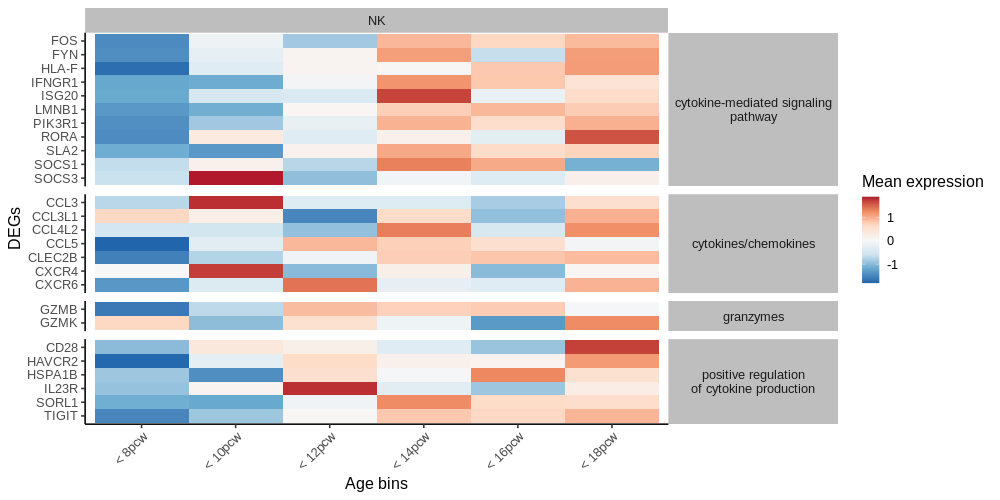

In [221]:
%%R -w 1000 -h 500
                
pl1 <- pl_df %>%
    group_by(gene, age_bins, annotation, gene_group) %>%
    summarise(mean_gex=mean(mean_gex), n=n()) %>%
    group_by(gene) %>%
#     mutate(mean_gex=(mean_gex - min(mean_gex))/(max(mean_gex) - min(mean_gex))) %>%
    mutate(mean_gex=(mean_gex - mean(mean_gex))/sd(mean_gex))%>%
    ungroup() %>%
    mutate(annotation='NK') %>%
#     filter(n_cells > 20) %>%
   ggplot(aes( age_bins, gene)) +
#     geom_point(aes(fill=mean_gex), shape=21) +
    geom_tile(aes(fill=mean_gex)) +
    facet_grid(gene_group~annotation, space="free", scales="free") +
#         scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression', limits=mean_gex_limits) +
    scale_fill_distiller(palette='RdBu', name='Mean expression') +
    guides(fill=guide_colorbar()) +
    ylab("DEGs") + xlab("Age bins") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1), 
          strip.text.y=element_text(angle=0),
          strip.background=element_rect(fill='grey', color=NA)
          #axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
         )

(pl1) +
    ggsave(paste0(figdir,"nk_figure.pdf"), width=8, height=8) 

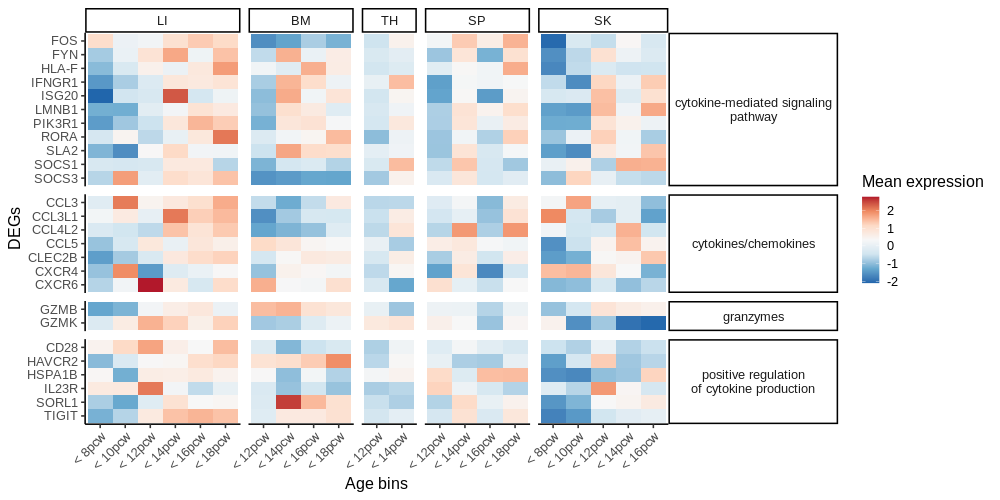

In [218]:
%%R -w 1000 -h 500
                
pl2 <- pl_df %>%
    group_by(gene) %>%
    mutate(mean_gex=(mean_gex - mean(mean_gex))/sd(mean_gex))%>%
    ungroup() %>%
    filter(n_cells > 20) %>%
   ggplot(aes( age_bins, gene)) +
    geom_tile(aes(fill=mean_gex)) +
    facet_grid(gene_group~organ, space="free", scales="free") +
    scale_fill_distiller(palette='RdBu', name='Mean expression') +
    guides(fill=guide_colorbar()) +
    ylab("DEGs") + xlab("Age bins") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1), 
          strip.text.y=element_text(angle=0)
          #axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
         )

(pl2) +
    ggsave(paste0(figdir,"nk_figure_split_organs.pdf"), width=13, height=8) 

### Final figures


In [413]:
highlight_ilc3 = {
    "ILC_progenitors":['ID2', "IL2RG"], 
       "neutrophil-degranulation":['PSMA2', 'COMMD3', 'NDUFC2', 'CTSD'], 
       'ox-phos':['NDUFB8', 'NDUFA11'],
       'G2/M transition':[ 'CDKN1A', 'UBE2C', 'CCNH', 'CDK1'],
        "TNFa/NFKb signalling":['CDKN1A', 'NINJ1', 'FOSL2', 'BIRC3'],               
        'more':['CXCR4', 'TNFRSF1B']               
}

highlight_NK = {
    'citokine-signalling':['CCL3L1',
 'DUSP1',
 'IFNGR1',
 'CCL5', ## involved in NK cell chemotaxis
 'CCL3', ## involved in NK cell chemotaxis
 'CXCR4',
 'RORA',
 'FYN',
 'FOS',
 'PIK3R1',
 'SLA2'], 
    'chemokines-citokines':['CLEC2B', "CCL4L2", 'CCL3L1'],
    'complement':['GZMK', 'SPOCK2', 'CCL5', 'GZMB', 'FYN'],
    'inflammatory_response':['CCR1', 'NCR3', 'GPR68', 'PTGER2', 'ITGB2', 'KLRG1']
    
}

#### NK cells

In [390]:
subset_organ = ["SP", "LI", "SK", "BM", "TH"]
subset_anno = ['NK']
highlight_genes = sum([list(x) for x in highlight_NK.values()],[])
genes = pd.read_csv(outdir + "DEGS_{a}_{o}_early.csv".format(a=subset_anno[0], o='-'.join(subset_organ)))['DEG']

## Exclude some that skew color scale
outliers = ['DNAJB1', "HSPA1B", "HSPA6"]
genes = [x for x in genes if x not in outliers]

In [391]:
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)
## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [392]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes -i highlight_genes
p1_highlight_nk <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, highlight_genes)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


In [393]:
subset_organ = ["SP", "LI", "SK", "BM", "TH"]
subset_anno = ['NK']
highlight_genes = sum([list(x) for x in highlight_NK.values()],[])
genes = pd.read_csv(outdir + "DEGS_{a}_{o}_late.csv".format(a=subset_anno[0], o='-'.join(subset_organ)))['DEG']

## Exclude some that skew color scale
outliers = ['DNAJB1']
genes = [x for x in genes if x not in outliers]

In [394]:
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)
## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
# scaled_df = (df.T - df.mean(1))/df.std(1)
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [395]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes -i highlight_genes
p2_highlight_nk <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, highlight_genes)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


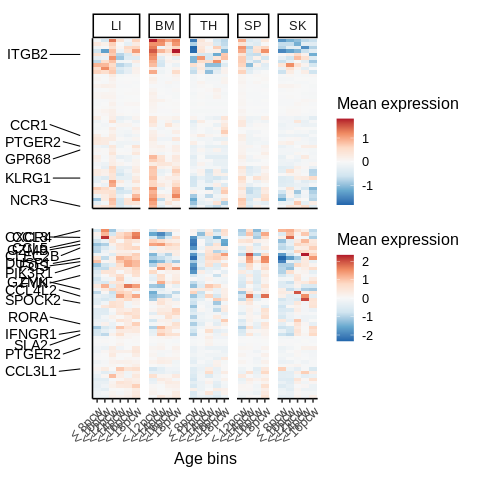

In [397]:
%%R
((p1_highlight_nk + remove_x_axis()) / (p2_highlight_nk + theme(strip.background=element_blank(), strip.text=element_blank(),))) + 
plot_layout(guides="collect") +
 ggsave(paste0(figdir, "NK_cells_DEGs_highlight.png"), width=10, height=10) + 
    ggsave(paste0(figdir, "NK_cells_DEGs_highlight.pdf"), width=12, height=8) 

#### ILC3 cells

In [425]:
subset_organ = ["SP", "LI", "SK", "BM", "TH"]
subset_anno = ['ILC3']
highlight_genes = sum([list(x) for x in highlight_ilc3.values()],[])
genes = pd.read_csv(outdir + "DEGS_{a}_{o}_early.csv".format(a=subset_anno[0], o='-'.join(subset_organ)))['DEG']

## Exclude some that skew color scale
outliers = ['SNHG25', "RPS10", "RPS17"]
genes = [x for x in genes if x not in outliers]

In [415]:
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)
## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
# scaled_df = (df.T - df.mean(1))/df.std(1)
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [416]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes -i highlight_genes
p1_highlight_ilc <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, highlight_genes)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


In [422]:
subset_organ = ["SP", "LI", "SK", "BM", "TH"]
subset_anno = ['ILC3']
highlight_genes = sum([list(x) for x in highlight_ilc3.values()],[])
genes = pd.read_csv(outdir + "DEGS_{a}_{o}_late.csv".format(a=subset_anno[0], o='-'.join(subset_organ)))['DEG']

## Exclude some that skew color scale
outliers = ['SNHG25', "RPS10", "RPS17"]
genes = [x for x in genes if x not in outliers]

In [418]:
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)
## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
# scaled_df = (df.T - df.mean(1))/df.std(1)
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [419]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes -i highlight_genes
p2_highlight_ilc <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, highlight_genes)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


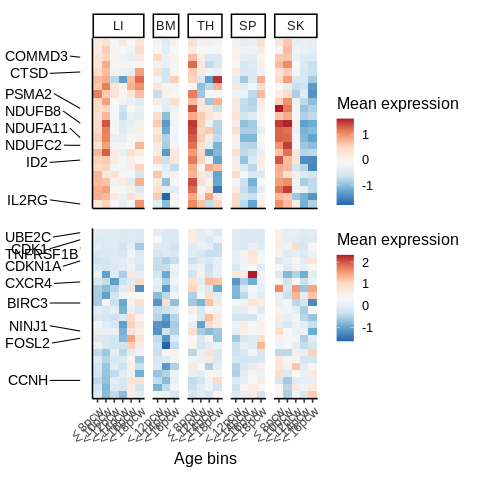

In [420]:
%%R
((p1_highlight_ilc + remove_x_axis()) / (p2_highlight_ilc + theme(strip.background=element_blank(), strip.text=element_blank(),))) + 
plot_layout(guides="collect") +
     ggsave(paste0(figdir, "ILC3_cells_DEGs_highlight.png"), width=10, height=6) + 
    ggsave(paste0(figdir, "ILC3_cells_DEGs_highlight.pdf"), width=10, height=6) 

---
---

# Junk n snippets

In [299]:
def plot_DGE_pbulk(test_adata, dge_df, subset_organ, subset_anno, FC_direction = None, n_genes=30, figsize=[4,10], save=False):
    ## Extract top genes and order by FC
    genes_df = dge_df.sort_values("pvals_adj")
    if FC_direction is not None:
        genes_df = genes_df[np.sign(genes_df.logfoldchanges) == FC_direction]
    genes = genes_df.iloc[0:n_genes].sort_values("logfoldchanges", ascending=False).names.values
  
    #     genes_dict = {}
    #     genes_dict["down"] = genes_df[genes_df["logfoldchanges"] < 0]['names'].values
    #     genes_dict["up"] = genes_df[genes_df["logfoldchanges"] > 0]['names'].values
    
    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
    pbulk_adata = anndata2pseudobulk(dge_res[3], group_by=["organ", "donor", "age_bins"], agg='m')
    pl_title = ''.join(subset_anno) + " - " + ''.join(subset_organ) 
    ax = sc.pl.heatmap(pbulk_adata, genes, groupby='age_bins', 
                       standard_scale=None, swap_axes=True, show=False,
                       figsize=figsize 
                      )
    fig = plt.gcf()
    print(len(fig.axes))
    plot_ax = fig.axes[1]
    cbar_ax = fig.axes[-1]
    cbar_ax.set_title("Mean\nexpression");
    bins_labels = dict(zip([str(x) for x in range(len(cut_labels_4))], cut_labels_4))
    plot_ax.set_xticklabels([bins_labels[x.get_text()] for x in plot_ax.get_xticklabels()], 
                            rotation=45, ha="right");
    if save:
        fig.savefig(figdir + pl_title + '_stacked_violin.png', bbox_inches="tight")

In [300]:
test_adata = dge_results[3][3].copy()
dge_df = dge_results[3][4].copy()

Trying to set attribute `.obs` of view, copying.
... storing 'organ' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'age_bins' as categorical


3


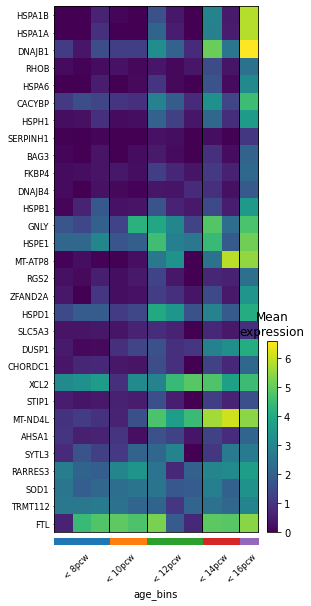

In [301]:
plot_DGE_pbulk(test_adata, dge_df, subset_organ, subset_anno, n_genes=30, FC_direction=1, save=False)

In [266]:
plot
pbulk_adata = anndata2pseudobulk(dge_res[3], group_by=["organ", "donor", "age_bins"], agg='m')
dge_df = dge_res[4]
genes_df = dge_df.sort_values("pvals_adj").iloc[0:n_genes]

sc.pl.heatmap(pbulk_adata, genes_df.names, groupby='age_bins', standard_scale=None, swap_axes=True)

### Early T cell subsets

In [263]:
hs_genes = adata.var_names[adata.var_names.str.startswith("HS")]
rp_genes = adata.var_names[adata.var_names.str.startswith("RP")]
mt_genes = adata.var_names[adata.var_names.str.startswith("MT-")]

Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical


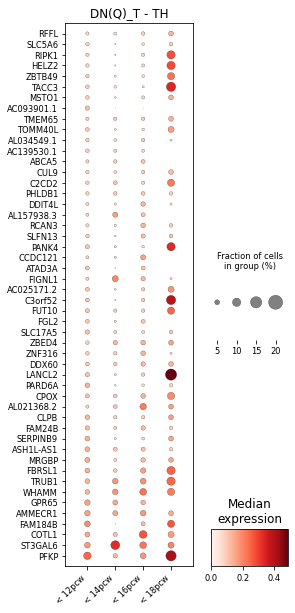

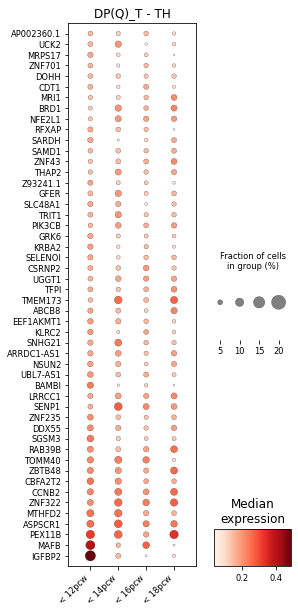

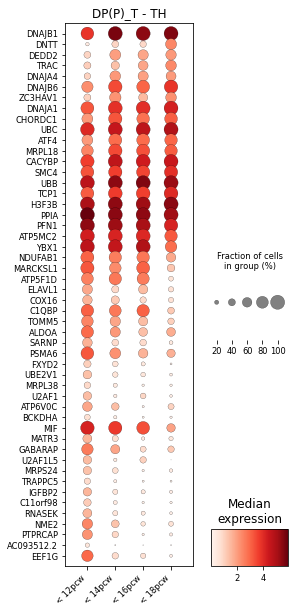

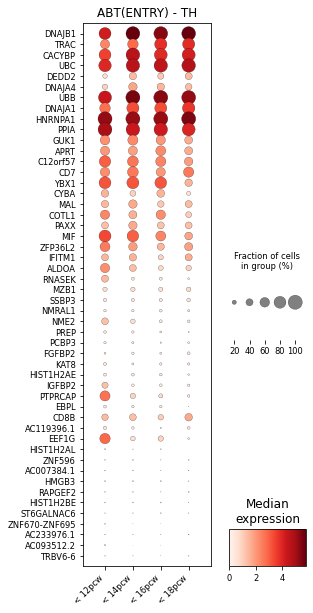

In [264]:
query_sets = [
    (["DN(Q)_T"],["TH"], "signif_late"),
    (["DP(Q)_T"],["TH"], "signif_late"),
    (["DP(P)_T"],["TH"], "signif_late"),
    (["ABT(ENTRY)"],["TH"], "signif_late"),
]

dge_results = []
for subset_anno, subset_organ, condition in query_sets:
    test_adata, dge_df = test_DGE(adata[adata.obs["age_bins"] >= 2][:,~adata.var_names.isin(hs_genes.tolist() + rp_genes.tolist() + mt_genes.tolist())], long_org_fc, subset_organ, subset_anno, condition=condition)
    ## Filter gene by mean expression
    genes = dge_df[dge_df.pvals_adj < 0.01]["names"]
#     age_means = np.empty(shape=[len(genes),0])
#     for a in test_adata.obs['age_bins'].unique():
#         age_mean = test_adata[:,genes].chunk_X(np.where(test_adata.obs['age_bins']==a)[0]).mean(0).reshape([len(genes),1])
#         age_means = np.concatenate([age_means,age_mean], 1)

#     age_means = age_means[:,test_adata.obs['age_bins'].unique().astype("int").argsort()]
#     ages = np.array(range(len(test_adata.obs['age_bins'].unique())))
#     cors = np.corrcoef(age_means, ages)
#     genes = genes[np.abs(cors[:-1,-1]) > 0.8]
    mean_expr = np.array(test_adata[:,genes].X.mean(0)).ravel()
    genes = genes[mean_expr > 0.05]
    
    plot_DGE(test_adata, dge_df[dge_df.names.isin(genes)], subset_organ, subset_anno, n_genes=50, save=True)
    dge_results.append([subset_anno, subset_organ, condition, test_adata, dge_df])

### NK cells

Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical


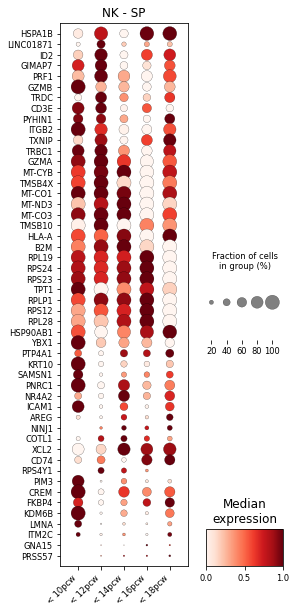

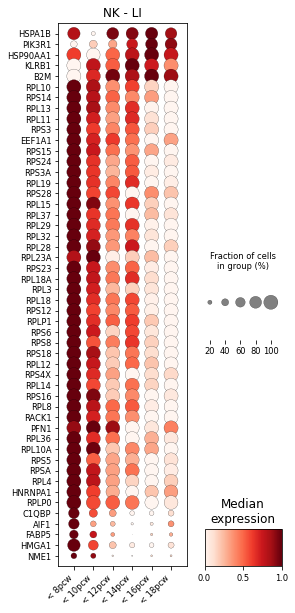

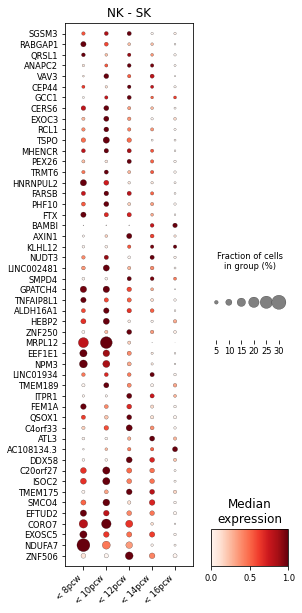

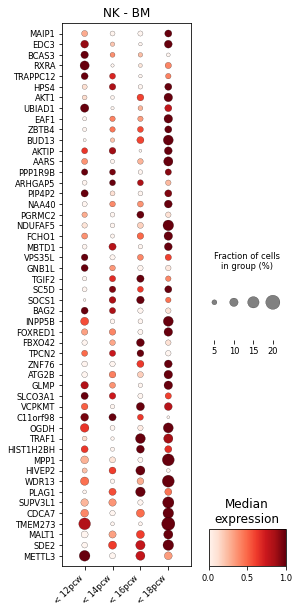

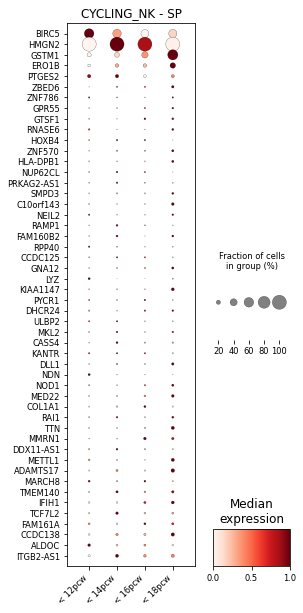

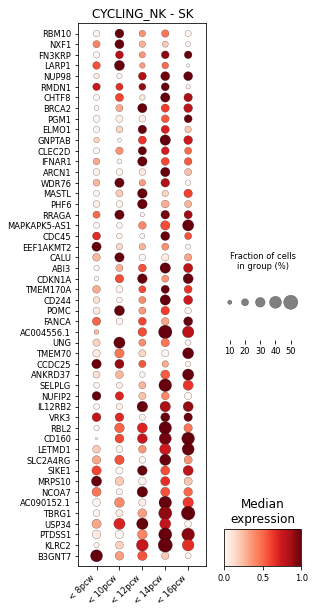

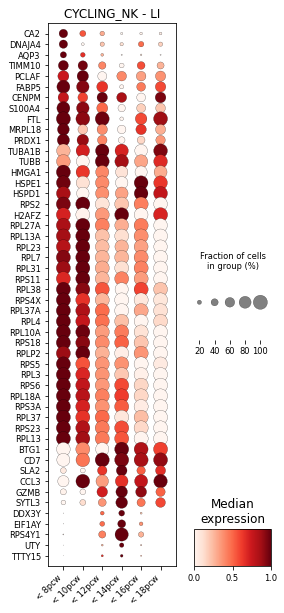

In [163]:
query_sets = [
    (["NK"],["SP"], "signif_early"),
    (["NK"],["LI"], "signif_late"), 
    (["NK"],["SK"], "signif_late"), 
    (["NK"],["BM"], "signif_early"), 
    (["CYCLING_NK"],["SP"], "signif_early"), 
    (["CYCLING_NK"],["SK"], "signif_early"), 
    (["CYCLING_NK"],["LI"], "signif_early"), 
]

dge_results = []
for subset_anno, subset_organ, condition in query_sets:
    test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition)
    plot_DGE(test_adata, dge_df, subset_organ, subset_anno, n_genes=50, save=True)
    dge_results.append([subset_anno, subset_organ, condition, test_adata, dge_df])

#### Focus on fetal liver
Exclude RP genes and Heat shock proteins

In [267]:
hs_genes = adata.var_names[adata.var_names.str.startswith("HS")]
rp_genes = adata.var_names[adata.var_names.str.startswith("RP")]

Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical


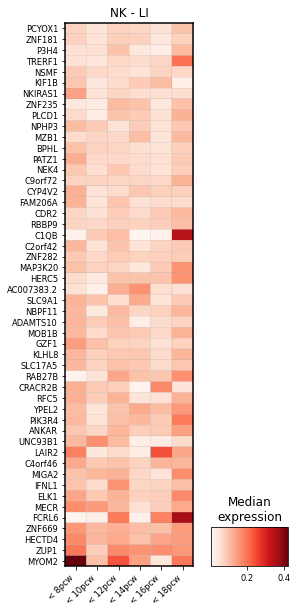

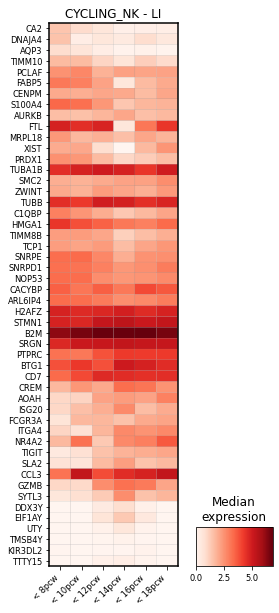

In [281]:
query_sets = [
    (["NK"],["LI"], "signif_early"), 
    (["CYCLING_NK"],["LI"], "signif_early"), 
]

dge_results = []
for subset_anno, subset_organ, condition in query_sets:
    test_adata, dge_df = test_DGE(adata[:,~adata.var_names.isin(hs_genes.tolist() + rp_genes.tolist())], long_org_fc, subset_organ, subset_anno, condition=condition)
    plot_DGE(test_adata, dge_df, subset_organ, subset_anno, n_genes=50, save=True)
    dge_results.append([subset_anno, subset_organ, condition, test_adata, dge_df])

- CD7 is a marker for lymphocytes, but early pre-NK cells are CD7-
- [here](https://www.jci.org/articles/view/68989) they say "NK cell differentiation in the human fetus starts before gestational week 15 and is stable from gestational week 15–22."
- KLRB1 is CD161
- GZMB: differentiation correlated with functional maturation

#### Focus on fetal spleen
Exclude RP genes and Heat shock proteins

Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical


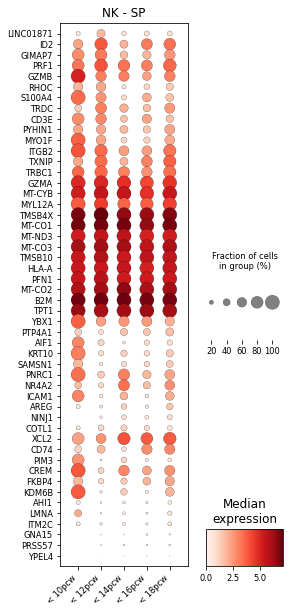

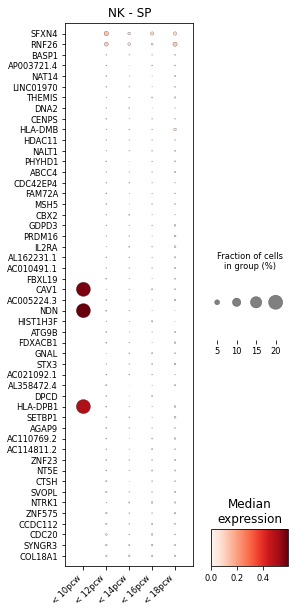

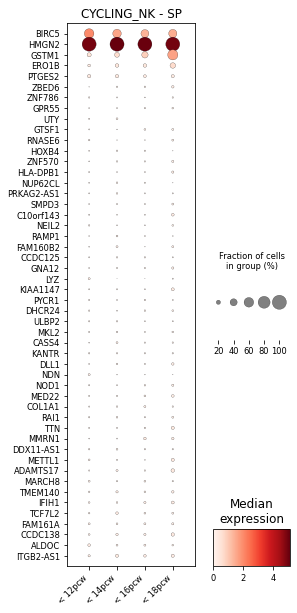

In [270]:
query_sets = [
    (["NK"],["SP"], "signif_early"),
    (["NK"],["SP"], "signif_late"),
    (["CYCLING_NK"],["SP"], "signif_early"), 
]

dge_results = []
for subset_anno, subset_organ, condition in query_sets:
    test_adata, dge_df = test_DGE(adata[:,~adata.var_names.isin(hs_genes.tolist() + rp_genes.tolist())], long_org_fc, subset_organ, subset_anno, condition=condition)
    plot_DGE(test_adata, dge_df, subset_organ, subset_anno, n_genes=50, save=True)
    dge_results.append([subset_anno, subset_organ, condition, test_adata, dge_df])

- early NKs in spleen express higher granzyme genes and perforin (PRF1), but lower XCL2, even if this paper says that fetal liver and spleen cells have similar phenotype https://www.frontiersin.org/articles/10.3389/fimmu.2019.00469/full#SM1

#### Extract SP and LI NK cells

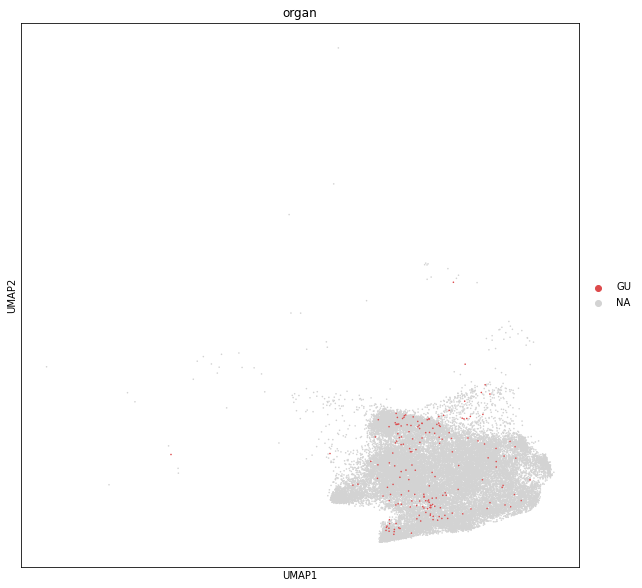

In [235]:
sc.pl.umap(adata[adata.obs["anno_lvl_2_final_clean"] == "NK"], color='organ', groups="GU", size=10)

In [241]:
milopy.utils.add_covariate_to_nhoods_var(adata, ["organ"])

In [263]:
early_li_nhoods = long_org_fc[(long_org_fc['nhood_anno'] == "NK") & (long_org_fc['organ'] == "LI") &  (long_org_fc['SpatialFDR'] < 0.1) & ( (long_org_fc['logFC'] > 0))]["Nhood"]

In [265]:
adata.uns["nhood_adata"][early_li_nhoods.astype("str")].X[:,adata.uns["nhood_adata"].var["organ"]=="GU"].toarray()

136.0

See how the early NK markers are expressed in other organs too

In [273]:
test_adata, dge_df = test_DGE(adata[:,~adata.var_names.isin(hs_genes.tolist() + rp_genes.tolist())], long_org_fc, subset_organ=["LI"], subset_anno=["CYCLING_NK"], condition="signif_early")

Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical


In [274]:
n_genes=50
## Extract top genes and order by FC
genes_df = dge_df.sort_values("pvals_adj").iloc[0:n_genes]
genes = genes_df.sort_values("logfoldchanges", ascending=False)["names"]

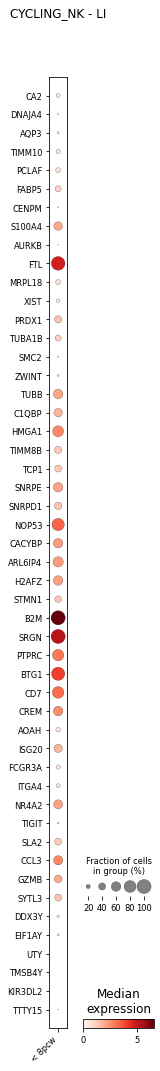

In [279]:
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
pl_title = ''.join(subset_anno) + " - " + ''.join(subset_organ) 
ax = sc.pl.dotplot(adata[(adata.obs["organ"]=="YS") & (adata.obs["anno_lvl_2_final_clean"]=="NK")], genes, groupby='age_bins', dendrogram=False, cmap="Reds", 
#                          standard_scale="var",
                         return_fig=False, swap_axes=True, show=False
                        );
fig = plt.gcf()
plot_ax = fig.axes[1]
cbar_ax = fig.axes[-1]
cbar_ax.set_title("Median\nexpression");
bins_labels = dict(zip([str(x) for x in range(len(cut_labels_4))], cut_labels_4))
plot_ax.set_xticklabels([bins_labels[x.get_text()] for x in plot_ax.get_xticklabels()], 
                        rotation=45, ha="right");

---

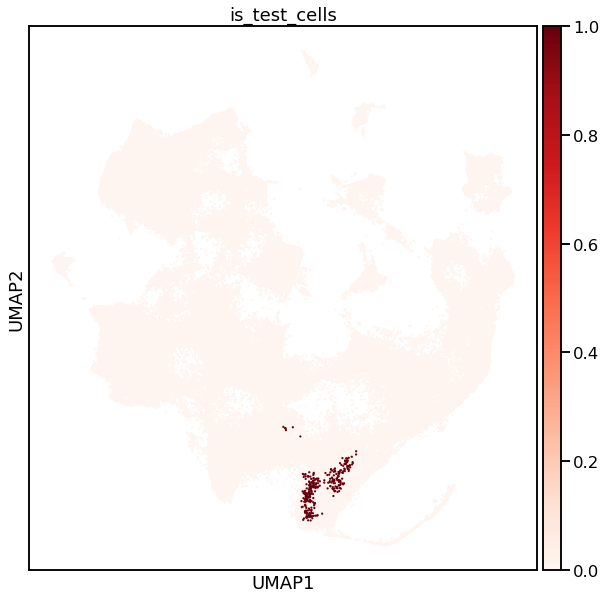

In [554]:
test_cells = test_adata.obs_names[test_adata.obs.test_condition=="case"]
adata.obs["is_test_cells"] = adata.obs_names.isin(test_cells).astype("int")

sc.pl.umap(adata, color=["is_test_cells"], size=20, cmap="Reds")

---
---

### Junk n snippets

In [233]:
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import STAP

def _test_lognormal_dge_limma(test_adata, model_contrasts="test_labelsignif_early-test_labelsignif_late"):
    r_fct_string = '''
    library(limma)
    perform_lognormal_dge <- function(exprs.data, 
                                      covariate, 
                                      design = "~0+test_label",
                                      gene.offset=TRUE,
                                      model_contrasts=NULL, 
                                      n.coef=NULL){

        test.model = model.matrix(as.formula(design), data=as.data.frame(covariate))

        if(isTRUE(gene.offset)){
            n.gene <- apply(exprs.data, 2, function(X) sum(X > 0))
            old.col <- colnames(test.model)
            if(all(test.model[, 1] == 1)){
                test.model <- cbind(test.model[, 1], n.gene, test.model[, c(2:ncol(test.model))])
                colnames(test.model) <- c(old.col[1], "NGenes", old.col[c(2:length(old.col))])
            } else{
                test.model <- cbind(n.gene, test.model)
                colnames(test.model) <- c("NGenes", old.col)
            }
        }

        i.fit <- lmFit(exprs.data, test.model)
        if(!is.null(model_contrasts)){
            mod.constrast <- makeContrasts(contrasts=model_contrasts, levels=test.model)
            i.fit <- contrasts.fit(i.fit, contrasts=mod.constrast)
            i.fit <- eBayes(i.fit, trend=TRUE)
            i.res <- as.data.frame(topTreat(i.fit, number = Inf, sort.by = "p", p.value = 1))
        } else{
            i.fit <- eBayes(i.fit, trend=TRUE)
            if(is.null(n.coef)){
                n.coef <- ncol(test.model)
            }

            i.res <- as.data.frame(topTreat(i.fit, coef=ncol(test.model), number = Inf, sort.by = "none", p.value = 1))
        }
        return(data.frame(i.res))
    }
    '''

    r_pkg = STAP(r_fct_string, "r_pkg")

    expr = test_adata.X.toarray()
    covariate = test_adata.obs[["test_label"]]
    gene_names = test_adata.var_names

    # CONVERT PYTHON NUMPY MATRICES TO R OBJECTS
    r_X = map(rpy2.robjects.numpy2ri, expr)
    r_cov = map(rpy2.robjects.pandas2ri, covariate)

    # PASS R OBJECTS INTO FUNCTION (WILL NEED TO EXTRACT DFs FROM RESULT)
    p_res = r_pkg.perform_lognormal_dge(expr.T, covariate, model_contrasts=model_contrasts)

    results = pd.DataFrame(p_res)
    results.index = gene_names

    return(results.sort_values("adj.P.Val"))

def label_early_and_late_nhoods(long_org_fc, subset_anno, 
                                subset_organ=None,
                                fc_cutoff = 0
                               ):
    if subset_organ is not None:
        keep_nhoods = long_org_fc['nhood_anno'].isin(subset_anno) & long_org_fc['organ'].isin(subset_organ)
    else:
        keep_nhoods = long_org_fc['nhood_anno'].isin(subset_anno)
    ## Take mean fold change across organs
    mean_fc = long_org_fc[keep_nhoods].groupby('Nhood').mean()["logFC"]

    ## Split based on fold-change cutoff
    late_nhoods = mean_fc > fc_cutoff
    early_nhoods = mean_fc < - fc_cutoff
    
    late_ixs = mean_fc.index[late_nhoods]
    early_ixs = mean_fc.index[early_nhoods]

    return(late_ixs, early_ixs, mean_fc)
    

In [234]:
def run_early_late_dge(long_org_fc, 
                       subset_anno,
                       subset_organ=None,
                       min_lfc=0.25,
                       min_n_nhoods=50):

    late,early,_ = label_early_and_late_nhoods(long_org_fc, subset_anno=subset_anno, subset_organ=subset_organ)
    nhood_adata = adata.uns["nhood_adata"].copy()
    anno_nhood_adata = nhood_adata[nhood_adata.obs["nhood_annotation"].isin(subset_anno)]

    test_label = ["early" if int(x) in (early -1 ) else "late" if int(x) in (late - 1) else np.nan for x in anno_nhood_adata.obs_names]
    anno_nhood_adata.obs["test_label"] = pd.Series(test_label).astype("category").values

    X_mat = anno_nhood_adata.obsm["expr"]
    test_adata = anndata.AnnData(X=X_mat, obs=anno_nhood_adata.obs, var=adata.var)
    test_adata = test_adata[~test_adata.obs["test_label"].isna()]

    ## Test differential expression
    dge_limma_df = _test_lognormal_dge_limma(test_adata)

    ## Extract top genes
    top_dge = dge_limma_df[(dge_limma_df['logFC'].abs() > min_lfc) & (dge_limma_df["adj.P.Val"] < 0.01)]

    top_early = top_dge[top_dge.logFC < 0].index
    top_late = top_dge[top_dge.logFC > 0].index
    
    params = {'subset_anno':subset_anno, "subset_organ":subset_organ, "min_lfc":min_lfc, 'min_n_nhoods':min_n_nhoods}
    return(top_early, top_late, params)

Test for DGE in interesting cell types

In [ ]:
import json

query_sets = [
    (["CD14+_MACROPHAGE"],["SK", "LI"]), 
    (["ILC3"],None), 
    (["HSC_MPP"], ["LI"]), 
    (["CD4+T", 'CD8+T'], ["TH"]),
    (['TREG'], ["TH"]),
    (['ABT(ENTRY)'], ["TH"]),
    (["DP(Q) T CELL", 'DP(P) T CELL'], ["TH"]),
    (["DN(Q) T CELL", 'DN(P)_DN(EARLY) T CELL'], ["TH"]),
    (["LATE_ERYTHROID", "MID_ERYTHROID", "EARLY_ERYTHROID"], ["LI"])
]

dge_results = []
for anno,org in query_sets:
    print(anno)
    early,late,params = run_early_late_dge(long_org_fc, anno, subset_organ=org, min_lfc=0.5)
    params["early_genes"] = early
    params["late_genes"] = late
    dge_results.append(params)

## Save to json
for i in range(len(dge_results)):
    dge_results[i]["early_genes"] = dge_results[i]["early_genes"].tolist()
    dge_results[i]["late_genes"] = dge_results[i]["late_genes"].tolist()
with open(data_dir + 'tmp/DGE_early_late_nhoods.json', 'w') as fout:
    json.dump(dge_results, fout)

['NK']


Trying to set attribute `.obs` of view, copying.


['ILC3']


Trying to set attribute `.obs` of view, copying.


In [ ]:
## Extract top genes
top_dge = dge_limma_df[(dge_limma_df['logFC'].abs() > min_lfc) & (dge_limma_df["adj.P.Val"] < 0.01)]

top_early = top_dge[top_dge.logFC < 0].index
top_late = top_dge[top_dge.logFC > 0].index

params = {'subset_anno':subset_anno, "subset_organ":subset_organ, "min_lfc":min_lfc, 'min_n_nhoods':min_n_nhoods}
return(top_early, top_late, params)